<a href="https://colab.research.google.com/github/MGabr/fm-next-songs-rec/blob/master/30Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">**30Music**</font>

This evaluation is done with the 30Music dataset which can be obtained at http://recsys.deib.polimi.it/datasets/.

The evaluation is done with only the more than 57k playlists from the dataset, not the listening histories.

First we load all needed libraries here.

In [0]:
%tensorflow_version 1.x

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import csv
import itertools
import json
import os
import time
import pickle
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import numba as nb
import scipy.sparse as sp
import tensorflow as tf
import tensorflow.sparse as tfs

# disable deprecation warnings
if type(tf.contrib) != type(tf): tf.contrib._warning = None

import logging
import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False


from google.colab import drive, files
from math import ceil, log2, floor, sqrt
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from statistics import mean
from timeit import timeit

In [0]:
nb.__version__

'0.47.0'

# Data loading and preprocessing

If the notebook is executed in google colaboratory, the compressed data set should be stored in the directory *datasets* on google drive. This google drive directory can then be mounted and the dataset decompressed. For mounting, access to google drive has to be granted and a received authorization code entered.

In [0]:
os.chdir("/")
drive.mount("/drive", force_remount=True)

!ls "/drive/My Drive/datasets"
!tar -xvf "/drive/My Drive/datasets/ThirtyMusic.tar.gz" --wildcards "entities/*"

os.chdir("/drive/My Drive/")
if not os.path.exists("models"):
  os.mkdir("models")
if not os.path.exists("models/30music"):
  os.mkdir("models/30music")
os.chdir("/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive
ThirtyMusic.tar.gz
entities/users.idomaar
entities/playlist.idomaar
entities/tracks.idomaar
entities/tags.idomaar
entities/persons.idomaar
entities/albums.idomaar


In [0]:
models_dirname = "/drive/My Drive/models/30music/"

In [0]:
def get_playlists_df():
  ps_names = ["type", "pid", "timestamp", "json1", "json2"]
  ps_usecols = ["pid", "timestamp", "json2"]
  df = pd.read_csv("entities/playlist.idomaar", sep="\t", names=ps_names,
                   usecols=ps_usecols)

  df_pid_time = df[["pid", "timestamp"]] 
  df = pd.io.json.json_normalize(df["json2"].apply(json.loads))
  s_userid = pd.io.json.json_normalize(df["subjects"].map(lambda l: l[0]))["id"]
  s_userid = s_userid.rename("userid")
  s = df["objects"].apply(pd.Series)
  df = df_pid_time.merge(s_userid, left_index=True, right_index=True)
  df = df.merge(s, left_index=True, right_index=True)

  df = pd.melt(df, ["pid", "timestamp", "userid"],
              var_name="trapos", value_name="trajson")
  df = df[df["trajson"].apply(isinstance, args=(dict,))]
  df["traid"] = df["trajson"].map(lambda d: d["id"])

  df = df[["pid", "timestamp", "userid", "traid"]]
  df.sort_values("pid", inplace=True, kind="mergesort")
  return df

df = get_playlists_df()
df.head()

,pid,timestamp,userid,traid
0,0,1216545588,41504,3006631
57561,0,1216545588,41504,1885124
115122,0,1216545588,41504,2548942
172683,0,1216545588,41504,1350486
230244,0,1216545588,41504,3734368


In [0]:
len(df)

1603040

In [0]:
def with_tracks_info(df):
  tracks_names = ["type", "traid", "timestamp", "json1", "json2"]
  tracks_usecols = ["traid", "json2"]
  tracks_df = pd.read_csv("entities/tracks.idomaar", sep="\t",
                          names=tracks_names, usecols=tracks_usecols)
  
  tracks_df = tracks_df[tracks_df["traid"].isin(df["traid"].drop_duplicates())]
  s_traid = tracks_df["traid"].reset_index()
  tracks_df = pd.io.json.json_normalize(tracks_df["json2"].apply(json.loads))
  tracks_df = tracks_df.merge(s_traid, left_index=True, right_index=True)
  tracks_df["artid"] = tracks_df["artists"].map(lambda a: a[0]["id"])
  tracks_df["albid"] = tracks_df["albums"].map(lambda a: a[0]["id"] if a else None)
  tracks_df.drop(columns=["artists", "albums", "tags"], inplace=True)
  
  # a track may have multiple entities - e.g. artists?
  # we drop multiple entities and take only the first
  tracks_df.drop_duplicates(subset=["traid"], inplace=True)

  # missing artist will get an id corresponding to their track
  # missing albums will get an id corresponding to their artist
  new_id_offset = 1000000
  tracks_df["artid"] = tracks_df["artid"].fillna(new_id_offset + tracks_df["traid"])
  tracks_df["albid"] = tracks_df["albid"].fillna(new_id_offset + tracks_df["artid"])

  df = df.join(tracks_df.set_index("traid"), on="traid")

  return df

df = with_tracks_info(df)
df.head()

,pid,timestamp,userid,traid,index,artid,albid
0,0,1216545588,41504,3006631,3497675,371862,3382.0
57561,0,1216545588,41504,1885124,1975475,236238,108772.0
115122,0,1216545588,41504,2548942,2648397,319762,146914.0
172683,0,1216545588,41504,1350486,1370043,170088,1170088.0
230244,0,1216545588,41504,3734368,4235809,464920,1464920.0


In [0]:
len(df)

1603040

In [0]:
def with_users_info(df):
  users_names = ["type", "userid", "timestamp", "json"]
  users_usecols = ["userid", "json"]
  users_df = pd.read_csv("entities/users.idomaar", sep="\t", names=users_names,
                         usecols=users_usecols)

  users_df = users_df[users_df["userid"].isin(df["userid"].drop_duplicates())]
  s_userid = users_df["userid"].reset_index()
  users_df = pd.io.json.json_normalize(users_df["json"].apply(yaml.load))
  users_df = users_df.merge(s_userid, left_index=True, right_index=True)
  users_df = users_df[["userid", "age", "country", "gender"]]

  df = df.join(users_df.set_index("userid"), on="userid")

  return df

df = with_users_info(df)
df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender
0,0,1216545588,41504,3006631,3497675,371862,3382.0,32.0,DE,m
57561,0,1216545588,41504,1885124,1975475,236238,108772.0,32.0,DE,m
115122,0,1216545588,41504,2548942,2648397,319762,146914.0,32.0,DE,m
172683,0,1216545588,41504,1350486,1370043,170088,1170088.0,32.0,DE,m
230244,0,1216545588,41504,3734368,4235809,464920,1464920.0,32.0,DE,m


In [0]:
len(df)

1603040

In [0]:
os.chdir("/drive/My Drive/")

After this, we can view statistics of the data set.

In [0]:
def get_statistics(df):
  num_inters = len(df)
  num_playlists = df["pid"].nunique()
  num_users = df["userid"].nunique()
  num_tracks = df["traid"].nunique()
  num_albums = df["albid"].nunique()
  num_artists = df["artid"].nunique()
  return num_inters, num_playlists, num_users, num_tracks, num_albums, num_artists


def print_statistics(df):
  print("{:,} interactions\n{:,} playlists\n{:,} users\n{:,} tracks\n{:,} albums\n{:,} artists"
        .format(*get_statistics(df)))

print_statistics(df)

1,603,040 interactions
48,422 playlists
15,102 users
466,244 tracks
140,807 albums
64,089 artists


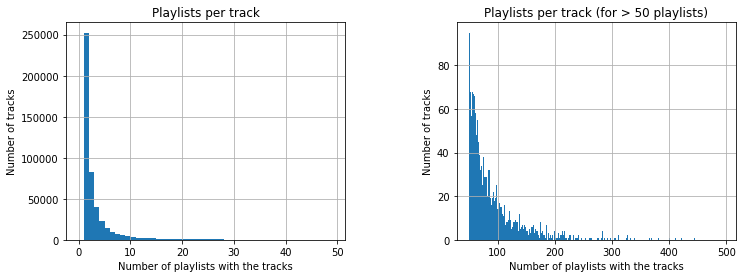

In [0]:
def plot_playlists_per_track(df):
  plt.figure(figsize=(12, 4))
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  
  plt.subplot(1, 2, 1)
  track_ps_df.hist(bins=range(0, 50))
  plt.ylabel("Number of tracks")
  plt.xlabel("Number of playlists with the tracks")
  plt.title("Playlists per track")

  plt.subplot(1, 2, 2)
  track_ps_df.hist(bins=range(50, track_ps_df.max()))
  plt.ylabel("Number of tracks")
  plt.xlabel("Number of playlists with the tracks")
  plt.title("Playlists per track (for > 50 playlists)")

  plt.subplots_adjust(wspace=0.4)

plot_playlists_per_track(df);

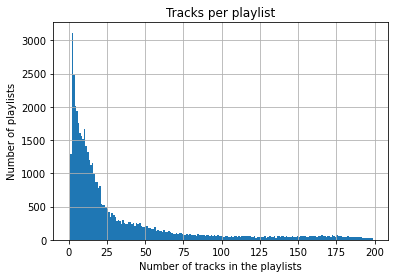

In [0]:
def plot_tracks_per_playlist(df):
  p_tracks_df = df[["pid", "traid"]].drop_duplicates()["pid"].value_counts()
  p_tracks_df.hist(bins=range(0, p_tracks_df.max()))
  plt.ylabel("Number of playlists")
  plt.xlabel("Number of tracks in the playlists")
  plt.title("Tracks per playlist")

plot_tracks_per_playlist(df);

In [0]:
def plot_both(df):
  plt.figure(figsize=(12, 4))
  
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  plt.subplot(1, 2, 1)
  track_ps_df.hist(bins=range(0, 50))
  plt.ylabel("#tracks")
  plt.xlabel("#playlists with the tracks")
  plt.title("Playlists per track")
  plt.grid(False);

  p_tracks_df = df[["pid", "traid"]].drop_duplicates()["pid"].value_counts()
  plt.subplot(1, 2, 2)
  p_tracks_df.hist(bins=range(0, p_tracks_df.max()))
  plt.ylabel("#playlists")
  plt.xlabel("#tracks in the playlists")
  plt.title("Tracks per playlist")
  plt.suptitle("30Music")
  plt.grid(False);

  plt.subplots_adjust(wspace=0.2)

As further preprocessing we remove the following:

*   Tracks ocurring in only one playlist: of small use
*   Playlists with less than 3 tracks: not useable for train-validation-test split

In [0]:
def with_min_track_ps(df, min_track_ps = 2):
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  rm_tracks_idx = track_ps_df[track_ps_df < min_track_ps].index
  df = df[~df["traid"].isin(rm_tracks_idx)]
  num_rm_tracks = rm_tracks_idx.size
  print("removed {:,} tracks which were in less than {} playlists"
        .format(num_rm_tracks, min_track_ps))
  return df

def with_min_p_inters(df, min_p_inters = 3):
  p_inters_df = df["pid"].value_counts()
  rm_p_idx = p_inters_df[p_inters_df < min_p_inters].index
  df = df[~df["pid"].isin(rm_p_idx)]
  num_rm_ps = rm_p_idx.size
  print("removed {:,} playlists which had less than {} track interactions\n"
        .format(num_rm_ps, min_p_inters))
  return df

df = with_min_track_ps(df)
df = with_min_p_inters(df)

print_statistics(df)

removed 252,370 tracks which were in less than 2 playlists
removed 5,519 playlists which had less than 3 track interactions

1,341,812 interactions
41,784 playlists
13,953 users
213,820 tracks
72,053 albums
32,458 artists


We also check if playlists sometimes contain the same track multiple times - and see that this is nearly never the case.

In [0]:
duplicates_df = df.groupby(["pid", "traid"]).size()
duplicates_df = duplicates_df[duplicates_df > 2].reset_index()

print("{:,} duplications in playlists\n".format(len(duplicates_df)))

duplicates_df.head()

3 duplications in playlists



,pid,traid,0
0,41463,453754,3
1,44211,3148952,3
2,53756,2647483,3


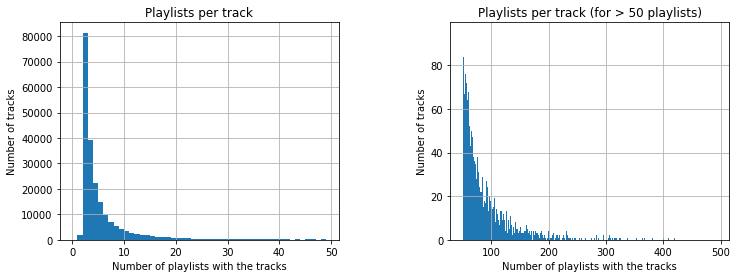

In [0]:
plot_playlists_per_track(df);

In [0]:
df[["pid", "traid"]].drop_duplicates()["traid"].value_counts().mean()

6.272051258067534

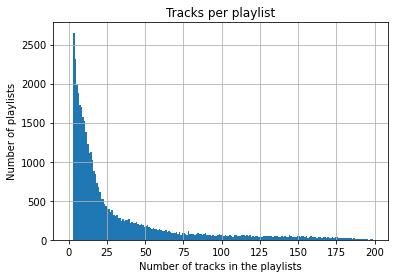

In [0]:
plot_tracks_per_playlist(df);

In [0]:
df[["pid", "traid"]].drop_duplicates()["pid"].value_counts().mean()

32.095778288340036

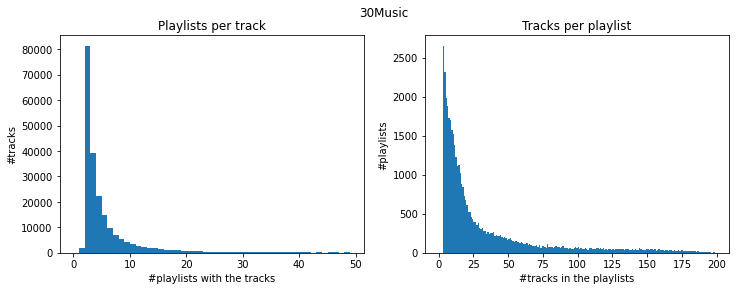

In [0]:
plot_both(df)

In [0]:
def plot_long_tail(df):
  track_counts = df["traid"].value_counts().sort_values(ascending=False)
  track_perc = track_counts.cumsum() / track_counts.sum()
  xlabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
  xticks = [x * track_counts.size for x in xlabels]
  track_perc.plot(use_index=False, ylim=(0.0, 1.0))
  plt.xticks(ticks=xticks, labels=xlabels)
  plt.ylabel("cumulative % of track occurence")
  plt.xlabel("% of tracks")
  plt.title("30Music")
  plt.grid(True);

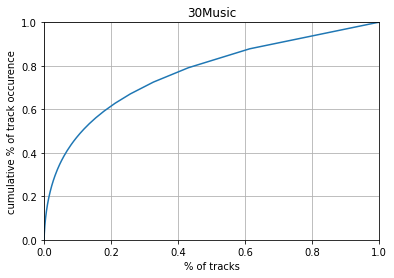

In [0]:
plot_long_tail(df)

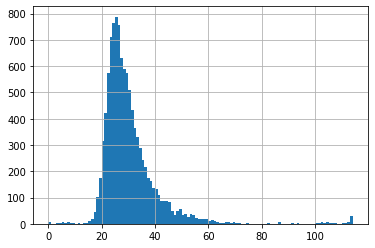

In [0]:
df[["userid", "age"]].drop_duplicates()["age"].hist(bins=int(df["age"].max()));

In [0]:
df["b_age"] = pd.cut(df["age"], [-1, 0, 15, 20, 25, 30, 35, 40, 50, 60, 110], right=False,
                        labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
df["b_age"].fillna(0, inplace=True)
df["b_age"] = df["b_age"].astype(int, copy=False)

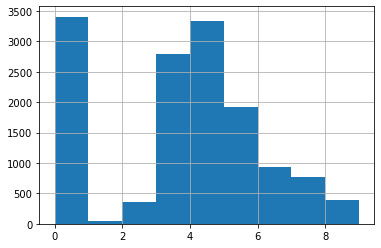

In [0]:
df[["userid", "b_age"]].drop_duplicates()["b_age"].hist(bins=int(df["b_age"].max()));

In [0]:
df["gender"].replace("n", None, inplace=True)
df["gender"].replace("", None, inplace=True)

In [0]:
df["country"].replace("", None, inplace=True)

Finally, we also add the previous track, album and artist as column.

In [0]:
def with_prev_columns(df):
  gp = df.groupby("pid")
  df["prev_traid"] = gp["traid"].shift(1)
  df["prev_albid"] = gp["albid"].shift(1)
  df["prev_artid"] = gp["artid"].shift(1)
  return df

df = with_prev_columns(df)
df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
0,0,1216545588,41504,3006631,3497675,371862,3382.0,32.0,DE,m,5,NaN,NaN,NaN
57561,0,1216545588,41504,1885124,1975475,236238,108772.0,32.0,DE,m,5,3006631.0,3382.0,371862.0
115122,0,1216545588,41504,2548942,2648397,319762,146914.0,32.0,DE,m,5,1885124.0,108772.0,236238.0
172683,0,1216545588,41504,1350486,1370043,170088,1170088.0,32.0,DE,m,5,2548942.0,146914.0,319762.0
230244,0,1216545588,41504,3734368,4235809,464920,1464920.0,32.0,DE,m,5,1350486.0,1170088.0,170088.0


# Evaluation split

First, we define functions for converting dataframe columns to one-hot indices in accordance with a train-test-validation split.

In [0]:
def col2id_col(df, col, mappings, rvs_mappings):
  if col in mappings:
    df[col] = df[col].map(mappings[col])
    df[col].fillna(0, inplace=True)
  else:
    df[col], rvs_mappings[col] = df[col].factorize()
    df[col] += 1
    rvs_mappings[col] = rvs_mappings[col].insert(0, None)
    mappings[col] = {col_val: i for i, col_val in enumerate(rvs_mappings[col])}

  df[col] = df[col].astype("int64", copy=False)


def df2id_df(df, id_cols, mappings, rvs_mappings):
  for id_col in id_cols:
    col2id_col(df, id_col, mappings, rvs_mappings)


def split_dfs2id_dfs(train_df, test_df=None, val_df=None, copy=True, cols=[],
                     same_col_pairs=[]):
  """
  Map columns of dataframes to one-hot indices.
  Test and validation dataframes will use the mappings of the train dataframe.
  Index 0 is used for missing and unknown (test and validation) column values.

  same_col_pairs are (src_col, same_col) pairs where same_col uses the same
  mappings as src_col.
  """
  id_mappings = dict()
  rvs_id_mappings = dict()
  
  if copy:
    train_df = train_df.copy()
    if test_df is not None:
      test_df = test_df.copy()
    if val_df is not None:
      val_df = val_df.copy()
  
  dfs = [df for df in [train_df, val_df, test_df] if df is not None]

  train_df = dfs[0]
  for df in dfs:
    df2id_df(df, cols, id_mappings, rvs_id_mappings)

  for src_col, same_col in same_col_pairs:
    id_mappings[same_col] = id_mappings[src_col]
  
  same_cols = [same_col for _, same_col in same_col_pairs]

  for df in dfs:
    df2id_df(df, same_cols, id_mappings, rvs_id_mappings)

  if copy:
    return tuple(dfs)

Now we set the columns we want to map to one-hot indices.

In [0]:
# columns to use
use_cols = ["pid", "userid", "country", "gender",
            "artid", "albid", "traid"]

# other columns to use with the same mappings as the previous columns
use_col_pairs = [("artid", "prev_artid"),
                 ("albid", "prev_albid"),
                 ("traid", "prev_traid")]

# which columns are user/context columns - and known as query context
non_track_cols = ["pid", "userid", "b_age", "country", "gender",
                  "prev_traid", "prev_albid", "prev_artid"]

# which columns are item columns - and known only as query seeds
track_cols = ["traid", "albid", "artid"]

Now we define the different evaluation splits to use. See section 5.1 of my master's thesis.

In [0]:
def _to_query_ctx(df):
  return df[non_track_cols]


def _to_query(concat_df):
  concat_df[track_cols] = concat_df[track_cols].fillna(0)
  concat_df[track_cols] = concat_df[track_cols].astype("int64", copy=False)
  return concat_df


def get_query_seeds(query_df):
  """
  Get the seed tracks of a query dataframe
  """
  return query_df[query_df["traid"] != 0]


def get_query_ctx(query_df):
  """
  Get the context of a query dataframe - 
  the actual target information without any target track information
  """
  return _to_query_ctx(query_df[query_df["traid"] == 0])


def _last_track_split(df, as_val):
  i = 2 if as_val else 1
  gp = df.groupby("pid")
  train_df = df[gp.cumcount(ascending=False) >= i]
  test_df = gp.nth(-i).reset_index()
  return train_df, test_df


def _users_split(df, n_test_users, seed):
  users = df["pid"].drop_duplicates()
  np.random.seed(seed)
  test_users = np.random.choice(users, n_test_users, replace=False)
  test_users_mask = df["pid"].isin(test_users)
  test_users_df = df[test_users_mask]
  train_users_df = df[~test_users_mask]
  return train_users_df, test_users_df


def _known_last_track_split(df, as_val, seed, n_test_users=None):
  train_df, test_df = _last_track_split(df, as_val)

  train_tracks = pd.Index(train_df["traid"].drop_duplicates())
  test_tracks = pd.Index(test_df["traid"].drop_duplicates())
  unknown_tracks = test_tracks.difference(train_tracks)
  unknown_mask = test_df["traid"].isin(unknown_tracks)
  unknown_pids = pd.Index(test_df[unknown_mask]["pid"])

  unknown_mask = df["pid"].isin(unknown_pids)
  known_df = df[~unknown_mask]
  unknown_df = df[unknown_mask]

  if n_test_users:
    train_users_df, test_users_df = _users_split(known_df, n_test_users, seed)
    train_df, test_df = _last_track_split(test_users_df, as_val)
    train_df = pd.concat([unknown_df, train_users_df, train_df], sort=False)
  else:
    train_df, test_df = _last_track_split(known_df, as_val)
    train_df = pd.concat([unknown_df, train_df], sort=False)

  train_df.sort_values("pid", inplace=True, kind="mergesort")

  return train_df, test_df


def _last_track_query(train_df, test_df, n_test_users=None):
  if n_test_users:
    test_pids = pd.Index(test_df["pid"])
    test_query_df = train_df[train_df["pid"].isin(test_pids)]
  else:
    test_query_df = train_df

  test_query_ctx_df = _to_query_ctx(test_df)
  test_query_df = pd.concat([test_query_df, test_query_ctx_df], sort=False)
  test_query_df = _to_query(test_query_df)

  return test_query_df


def last_track_split(df, as_val=False, n_test_users=None, seed=1):
  """
  Split the dataframe into train and validation or test dataframes.
  The test dataframe contains the last track of each or n_test_users random
  users, the validation dataframe the second-last. Only returns validation or 
  test users with known (second-)last track indices.

  Also returns a query dataframe corresponding to the validation or test
  dataframe.

  Columns are mapped to one-hot indices in the process. 
  """
  train_df, test_df = _known_last_track_split(df, as_val, seed, n_test_users)

  train_df, test_df = split_dfs2id_dfs(train_df, test_df=test_df, cols=use_cols,
                                       same_col_pairs=use_col_pairs)

  return train_df, test_df, _last_track_query(train_df, test_df, n_test_users)


def _seed_users_split(df, n_test_users, include_val, n_seed_tracks, seed):
  gp = df.groupby("pid")
  seed_df = gp.filter(lambda g: g.size > n_seed_tracks)
  non_seed_df = gp.filter(lambda g: g.size <= n_seed_tracks)

  train_df, test_df = _users_split(seed_df, n_test_users, seed)

  val_df = None
  if include_val:
    train_df, val_df = _users_split(train_df, n_test_users, seed)

  train_df = pd.concat([train_df, non_seed_df], sort=False)
  train_df.sort_values("pid", inplace=True, kind="mergesort")

  if include_val:
    return train_df, val_df, test_df
  else:
    return train_df, test_df


def _seed_query_split(df, n_seed_tracks):
  gp = df.groupby("pid", as_index=False)
  test_df = df[gp.cumcount() >= n_seed_tracks]
  query_df = gp.head(n_seed_tracks)
  query_ctx_df = _to_query_ctx(gp.nth(n_seed_tracks))
  query_df = _to_query(pd.concat([query_df, query_ctx_df], sort=False))
  query_df.sort_values("pid", inplace=True, kind="mergesort")
  return test_df, query_df


def users_split(df, n_test_users, include_val=False, n_seed_tracks=5, seed=1):
  """
  Split the dataframe into train, optional validation and test dataframes.
  The test and validation dataframe each contain n_test_users users and
  the train dataframe the other users. The validation and test dataframes
  each contain the users tracks after his/her first n_seed_tracks tracks.
  Only returns validation or test users with more than n_seed_tracks tracks.

  Also returns query dataframes corresponding to the validation and test
  dataframes.

  Columns are mapped to one-hot indices in the process,
  but train, validation and test dataframes have separate pid indices,
  all start from 0!
  """
  # TODO: known
  dfs = _seed_users_split(df, n_test_users, include_val, n_seed_tracks, seed)

  # pids are separate for each split - all start from 0, to different n
  dfs = (split_dfs2id_dfs(df, cols=["pid"])[0] for df in dfs)
  if include_val:
    train_df, val_df, test_df = dfs
  else:
    train_df, test_df = dfs
    val_df = None

  # TODO: use_cols without pid
  split_dfs2id_dfs(train_df, test_df=test_df, val_df=val_df, cols=use_cols,
                   same_col_pairs=use_col_pairs, copy=False)
  
  test_df, test_query_df = _seed_query_split(test_df, n_seed_tracks)
  val_query_df = None
  if include_val:
    val_df, val_query_df = _seed_query_split(val_df, n_seed_tracks)

  dfs = train_df, val_df, test_df, val_query_df, test_query_df
  return tuple(df for df in dfs if df is not None)

We now create a last track split and view the structure of the results.

In [0]:
train_df, test_df, test_query_df = last_track_split(df, n_test_users=1000)

In [0]:
train_df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
0,1,1216545588,1,1,3497675,1,1,32.0,1,1,5,0,0,0
57561,1,1216545588,1,2,1975475,2,2,32.0,1,1,5,1,1,1
115122,1,1216545588,1,3,2648397,3,3,32.0,1,1,5,2,2,2
172683,1,1216545588,1,4,1370043,4,4,32.0,1,1,5,3,3,3
230244,1,1216545588,1,5,4235809,5,5,32.0,1,1,5,4,4,4


In [0]:
test_df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
0,11,1294318230,5,25514,186385,7800,13829,24.0,4,1,3,364,273,212
1,46,1275510507,19,22057,664245,780,1001,22.0,11,2,3,1298,1001,780
2,93,1291546547,38,5765,3080515,2518,3831,28.0,24,2,4,2425,1725,1260
3,136,1281597335,51,3627,4275402,1743,2490,25.0,12,2,4,3695,2490,1743
4,161,1236352414,58,151982,1310594,2391,3717,NaN,14,1,0,4224,2884,224


In [0]:
get_query_seeds(test_query_df).head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
12,11,1.294318e+09,5,359,1357583.0,208,269,24.0,4,1,3,0,0,0
57573,11,1.294318e+09,5,360,1357629.0,208,269,24.0,4,1,3,359,269,208
115134,11,1.294318e+09,5,361,1986356.0,209,270,24.0,4,1,3,360,269,208
172695,11,1.294318e+09,5,362,3511770.0,210,271,24.0,4,1,3,361,270,209
230256,11,1.294318e+09,5,363,3788168.0,211,272,24.0,4,1,3,362,271,210


In [0]:
get_query_ctx(test_query_df).head()

,pid,userid,b_age,country,gender,prev_traid,prev_albid,prev_artid
0,11,5,3,4,1,364,273,212
1,46,19,3,11,2,1298,1001,780
2,93,38,4,24,2,2425,1725,1260
3,136,51,4,12,2,3695,2490,1743
4,161,58,0,14,1,4224,2884,224


# Evaluation metrics

As evaluation metrics we will use NDCG and hit rates / recall@n.

In [0]:
def with_time(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if result is None:
          return (te - ts)
        else:
          return result, (te - ts)
          
    return timed


def hit_rate(pred_tracks_df, true_tracks_df, n=1):
  """
  Computes the mean user hit rate.
  
  Assumes
   * pred_tracks_df sorted by score per pid
   * true_tracks_df has only one true track per pid!
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(n)
  hits = len(pred_tracks_df.join(true_tracks_df.set_index(["pid", "traid"]),
                                 on=["pid", "traid"], how="inner"))
  hit_rate = hits / pred_tracks_df["pid"].nunique()
  
  return hit_rate


def hit_rates(pred_tracks_df, true_tracks_df, max_n=500):
  """
  Computes the mean user hit rate for each n up to max_n.
  
  Assumes pred_tracks_df sorted by score per pid
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(max_n)
  
  hits = pred_tracks_df
  hits["n"] = hits.groupby("pid").cumcount()
  true_tracks_df["r"] = true_tracks_df.groupby("pid")["traid"].transform("size")
  hits = hits.join(true_tracks_df.set_index(["pid", "traid"]),
                   on=["pid", "traid"], how="inner")
  hits["hits"] = 1.0 / hits["r"]
  
  cum_hits = hits.groupby("n")["hits"].sum().cumsum()
  cum_hits = cum_hits.reindex(range(0, max_n), method="pad")
  cum_hits.fillna(0.0, inplace=True)
  
  cum_hit_rates = cum_hits.to_numpy() / pred_tracks_df["pid"].nunique()
  
  return cum_hit_rates


def ndcg(pred_tracks_df, true_tracks_df, n=500):
  """
  Computes the mean user NDCG.
  
  Assumes pred_tracks_df sorted by score per pid
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(n)
  true_tracks_df = true_tracks_df.groupby("pid").head(n)
  
  dcgs = pred_tracks_df
  dcgs["n"] = dcgs.groupby("pid").cumcount()
  dcgs = dcgs.join(true_tracks_df.set_index(["pid", "traid"]),
                   on=["pid", "traid"], how="inner")
  dcgs["dcg"] = 1.0 / np.log2(dcgs["n"].to_numpy() + 2)
  dcg = dcgs.groupby("pid")["dcg"].sum()
  
  idcgs = true_tracks_df
  idcgs["n"] = idcgs.groupby("pid").cumcount()
  idcgs["dcg"] = 1.0 / np.log2(idcgs["n"].to_numpy() + 2)
  idcg = idcgs.groupby("pid")["dcg"].sum()
  
  return (dcg / idcg).sum()  / pred_tracks_df["pid"].nunique()

# Baseline algorithms

Now we want to evaluate some baseline algorithms on the dataset. We will use the following algorithms.

*   PopRank
*   Same Artist - Greatest Hits (SAGH)
*   kNN user-based collaborative filtering

These algorithms were presented and evaluated for playlist generation in


> Geoffray Bonnin and Dietmar Jannach.<br>
> **Automated generation of music playlists:Survey and experiments**.<br>
> *In ACM CSUR, pages 26:1--26:35, 2015*

## Implementation

In [0]:
def df2csr(df, cols, nodup=True, shape=None, return_df=False):
  """
  Converts a dataframe with 2 or 3 columns into a csr matrix where
   * column 1 are the row indices
   * column 2 are the column indices
   * column 3 are the values or all values are one

  This csr matrix can be more efficient to work with in some algorithms
  """
  
  rowcol = cols[0]
  colcol = cols[1]
  valcol = cols[2] if len(cols) > 2 else None
    
  if nodup:
    dfcols = [col for col in cols if col]
    df = df[dfcols].drop_duplicates()
  
  row_arr = df[rowcol].to_numpy()
  col_arr = df[colcol].to_numpy()
  val_arr = df[valcol].to_numpy() if valcol else np.ones(row_arr.shape)
  
  mat = csr_matrix((val_arr, (row_arr, col_arr)), shape=shape)
  
  if not nodup:
    mat.sum_duplicates()
  
  if return_df:
    return mat, df
  
  return mat


class TrackArtistEnricher:
  
  def fit(self, train_df):
    self.tra_art_s = (train_df[["traid", "artid"]]
                      .drop_duplicates()
                      .append(pd.DataFrame({"traid": [0], "artid": [0]}))
                      .set_index("traid"))
  
  def transform(self, df):
    return df.join(self.tra_art_s, on="traid")

  
t_cols = ["score", "pid", "traid"]

In [0]:
class PopRank:
  
  @with_time
  def fit(self, train_df, count_listens=False, tf=False):
    nodup = not count_listens and not tf
    tra_user_mat = df2csr(train_df, ["traid", "pid"], nodup=nodup)
    
    if tf:
      tra_user_mat.data = np.log2(1 + tra_user_mat.data)

    scores = tra_user_mat.sum(axis=1).A.reshape(-1)
    
    self.scores_s = pd.Series(data=scores, name="score")
    self.scores_s.index.name = "traid"
  
  def transform_no_filter(self, query_df, n):
    users_df = query_df[["pid"]].drop_duplicates()
    users_df["tmpkey"] = 0
    t_df = self.scores_s.nlargest(n).reset_index().copy()
    t_df["tmpkey"] = 0
    return users_df.merge(t_df, on="tmpkey")
  
  def transform_filter(self, query_df, n):    
    gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
    m = gp.size().max()
    
    # trick for efficiently filtering user tracks
    # use mutable scores series
    # 
    #  1. get best n + m (maximum user tracks) sorted scores
    nmlargest_idx = self.scores_s.nlargest(n + m).index.to_numpy()

    t_dfs = []
    for userid, user_df in gp:
      user_tracks = user_df["traid"].to_numpy()
      
      #  2. set scores of filtered tracks to 0 - changes df state
      tmpscores = self.scores_s.iloc[user_tracks]
      self.scores_s.iloc[user_tracks] = 0.0

      sorted_scores = self.scores_s.iloc[nmlargest_idx].to_numpy()

      #  3. get best n sorted scores without added 0s
      nonzero_idx = np.nonzero(sorted_scores)[0][:n]
      resorted_idx = nmlargest_idx[nonzero_idx]

      #  4. reset 0 scores - changes df state back
      t_s = self.scores_s.iloc[resorted_idx]

      self.scores_s.iloc[user_tracks] = tmpscores

      t_df = t_s.reset_index()
      t_df["pid"] = userid
      t_dfs.append(t_df)
    
    return pd.concat(t_dfs, sort=False)
  
  @with_time
  def transform(self, query_df, n=500, filter_user_tracks=False):
    if filter_user_tracks:
      t_df = self.transform_filter(query_df, n)
    else:
      t_df = self.transform_no_filter(query_df, n)
    
    return t_df[t_cols]

In [0]:
class SAGH:
  
  @with_time
  def fit(self, train_df, count_listens=False, tf=False):
    self.pop_rank = PopRank()
    self.pop_rank.fit(train_df, count_listens=count_listens, tf=tf)
    
    art_en = TrackArtistEnricher()
    art_en.fit(train_df)
    art_tra_scores_df = art_en.transform(self.pop_rank.scores_s.reset_index())
    art_tra_scores_df.drop(0, inplace=True)  # remove missing artists
    
    self.art_tra_mat = df2csr(art_tra_scores_df,
                              ["artid", "traid", "score"],
                              nodup=True)
  
  @with_time
  def transform(self, query_df, n=500, filter_user_tracks=False):
    userids = query_df["pid"].drop_duplicates()  
    user_art_mat = df2csr(query_df, ["pid", "artid"],
                          nodup=True,
                          shape=(userids.max() + 1, self.art_tra_mat.shape[0]))

    # popularity scores of tracks of same artists
    tra_scores_mat = user_art_mat * self.art_tra_mat

    if filter_user_tracks:
      # trick for efficiently filtering user tracks
      # use same mutable mask for each user 
      gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
      tracks_mask = np.ones(self.art_tra_mat.shape[1])
    else:
      gp = ((userid, None) for userid in userids)

    t_dfs = []      
    for userid, user_df in gp:
      start = time.time()

      l = tra_scores_mat.indptr[userid]
      r = tra_scores_mat.indptr[userid + 1]

      userids = np.full(r - l, userid)
      tracks = tra_scores_mat.indices[l:r]
      scores = tra_scores_mat.data[l:r]

      t_df = pd.DataFrame({"pid": userids, "traid": tracks, "score": scores})

      if filter_user_tracks:
        user_tracks = user_df["traid"].to_numpy()
        tracks_mask[user_tracks] = 0
        
        t_df = t_df.nlargest(n + len(user_tracks), "score")
        n_offsets = np.nonzero(tracks_mask[t_df["traid"].to_numpy()])[0][:n]
        t_df = t_df.iloc[n_offsets]
        
        tracks_mask[user_tracks] = 1
      else:
        t_df = t_df.nlargest(n, "score")
      
      t_dfs.append(t_df)

    return pd.concat(t_dfs, sort=False)[t_cols]

In [0]:
class KNN:
  
  @with_time
  def fit(self, train_df, count_listens=False, tfidf=False):    
    self.user_tra_mat = df2csr(train_df, ["pid", "traid"], nodup=not tfidf)
    
    self.tfidf_trans = None
    if tfidf:
      self.tfidf_trans = TfidfTransformer(sublinear_tf=True)
    if count_listens:
      self.tfidf_trans = TfidfTransformer(norm=None, use_idf=False)
    if tfidf or count_listens:
      self.user_tra_mat = self.tfidf_trans.fit_transform(self.user_tra_mat)
    
    # for cosine similarity
    self.tra_user_normalized = normalize(self.user_tra_mat).T
  
  @with_time
  def transform(self, query_df, n=500, k=50, filter_user_tracks=False):    
    mat = df2csr(query_df, ["pid", "traid"],
                 nodup=not self.tfidf_trans,
                 shape=self.user_tra_mat.shape)
    
    if self.tfidf_trans:
      mat = self.tfidf_trans.transform(mat)

    normalize(mat, copy=False)  # for cosine similarity
    
    # cosine similarity
    # this needs O(n^2) memory for n users, but is stored sparse at least
    nn_scores = mat * self.tra_user_normalized
    
    if filter_user_tracks:
      # trick for efficiently filtering user tracks
      # use same mutable mask for each user 
      gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
      tracks_mask = np.ones(self.user_tra_mat.shape[1])
    else:
      gp = ((i, i) for i in range(self.user_tra_mat.shape[0]))

    t_dfs = []
    for userid, user_df in gp:
      # k nearest neighbors by cosine similarity
      l = nn_scores.indptr[userid]
      r = nn_scores.indptr[userid + 1]
      if (r - l) <= k:
        nn_users = nn_scores.indices[l:r]
      else:
        k_offsets = np.argpartition(nn_scores.data[l:r], -k)[-k:]
        nn_users = nn_scores.indices[l + k_offsets]

      # track scores as tracks of neighbors weighted by cosine similarity
      scores =  nn_scores[userid,nn_users] * self.user_tra_mat[nn_users,:]

      userids = np.full(len(scores.indices), userid)
      tracks = scores.indices
      scores = scores.data
      
      t_df = pd.DataFrame({"pid": userids, "traid": tracks, "score": scores})
      
      if filter_user_tracks:
        user_tracks = user_df["traid"].to_numpy()
        tracks_mask[user_tracks] = 0
        
        t_df = t_df.nlargest(n + user_tracks.size, "score")
        n_offsets = np.nonzero(tracks_mask[t_df["traid"].to_numpy()])[0][:n]
        t_df = t_df.iloc[n_offsets]
        
        tracks_mask[user_tracks] = 1
      else:
        t_df = t_df.nlargest(n, "score")
        
      t_dfs.append(t_df)
    
    return pd.concat(t_dfs, sort=False)[t_cols]

## Evaluation

In our evaluation we filter out tracks that are already in the playlist (*filter_user_tracks*), even though a sizeable number of tracks are contained in a playlist multiple times. We therefore also don't use the *count_listens* or *tf* parameters.

In [0]:
pop_rank = PopRank()
pop_rank_fit_time = pop_rank.fit(train_df)
pop_rank_df, pop_rank_trans_time = pop_rank.transform(
    get_query_seeds(test_query_df), filter_user_tracks=True)
pop_rank_hit_rates = hit_rates(pop_rank_df, test_df)
pop_rank_ndcg = ndcg(pop_rank_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(pop_rank_hit_rates[0], pop_rank_ndcg, pop_rank_fit_time,
              pop_rank_trans_time))

0.001000 hit rate
0.009733 ndcg

0.24085s fit time 
4.07988s trans time


In [0]:
del pop_rank

In [0]:
sagh = SAGH()
sagh_fit_time = sagh.fit(train_df)
sagh_df, sagh_trans_time = sagh.transform(get_query_seeds(test_query_df),
                                          filter_user_tracks=True)
sagh_hit_rates = hit_rates(sagh_df, test_df)
sagh_ndcg = ndcg(sagh_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(sagh_hit_rates[0], sagh_ndcg, sagh_fit_time, sagh_trans_time))

0.016032 hit rate
0.068167 ndcg

0.46980s fit time 
4.68180s trans time


In [0]:
del sagh
del sagh_df

In [0]:
train_df, val_df, val_query_df = last_track_split(df, as_val=True,
                                                  n_test_users=1000)

In [0]:
ks = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
knn = KNN()
knn_fit_time = knn.fit(train_df)

knn_hit_rates = dict()
knn_ndcgs = dict()

for k in ks:
  knn_df, _= knn.transform(get_query_seeds(val_query_df), k=k,
                           filter_user_tracks=True)
  knn_hit_rates[k] = hit_rates(knn_df, val_df)
  knn_ndcgs[k] = ndcg(knn_df, val_df)

In [0]:
rows = [[knn_ndcgs[k] for k in ks], [knn_hit_rates[k][0] for k in ks]]
index = ["NDCG", "Hit rate"]        
pd.DataFrame.from_records(rows, columns=ks, index=index)

,10,50,100,150,200,250,300,350,400,450,500,1000
NDCG,0.057428,0.076076,0.079553,0.080984,0.080718,0.080128,0.079574,0.079468,0.078289,0.078602,0.078464,0.076997
Hit rate,0.012024,0.020040,0.020040,0.021042,0.021042,0.021042,0.021042,0.021042,0.021042,0.022044,0.022044,0.022044


The best k - *150* - is then used for the evaluation.

In [0]:
train_df, test_df, test_query_df = last_track_split(df, n_test_users=1000)

In [0]:
knn = KNN()
knn_fit_time = knn.fit(train_df)
knn_df, knn150_trans_time = knn.transform(get_query_seeds(test_query_df), k=150,
                                          filter_user_tracks=True)
knn150_hit_rates = hit_rates(knn_df, test_df)
knn150_ndcg = ndcg(knn_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(knn150_hit_rates[0], knn150_ndcg, knn_fit_time,
              knn150_trans_time))

0.021000 hit rate
0.069371 ndcg

0.22501s fit time 
5.63226s trans time


In [0]:
del knn
del knn_df

In [0]:
cols = ["Pop Rank", "SAGH", "kNN k=150"]
rows = [[pop_rank_ndcg, sagh_ndcg, knn150_ndcg],
        [pop_rank_hit_rates[0], sagh_hit_rates[0], knn150_hit_rates[0]]]
index = ["NDCG", "Hit rate"]
pd.DataFrame.from_records(rows, columns=cols, index=index)

,Pop Rank,SAGH,kNN k=150
NDCG,0.009733,0.068167,0.069371
Hit rate,0.001000,0.016032,0.021000


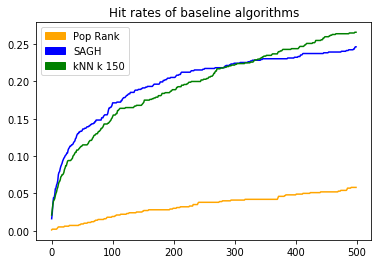

In [0]:
def plot_baseline_hit_rates(n=500):
  plt.plot(pop_rank_hit_rates[:n], color="orange")
  plt.plot(sagh_hit_rates[:n], color="blue")
  plt.plot(knn150_hit_rates[:n], color="green")

  orange_patch = mpatches.Patch(color="orange", label="Pop Rank")
  blue_patch = mpatches.Patch(color="blue", label="SAGH")
  green_patch = mpatches.Patch(color="green", label="kNN k 150")
  patches = [orange_patch, blue_patch, green_patch]
  plt.legend(handles=patches)

  plt.title("Hit rates of baseline algorithms")
  
plot_baseline_hit_rates();

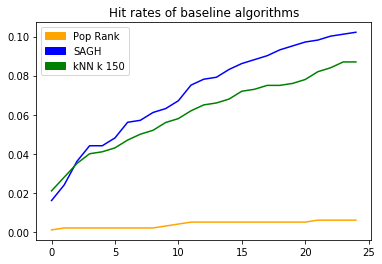

In [0]:
plot_baseline_hit_rates(n=25);

## Cold start evaluation

Besides an evaluation using a last-track split where we recommend the last track for each playlist we also perform an evaluation using a playlist split where we recommend all missing tracks for beginnings (5 tracks) of playlists which were entirely unknown during training.

In [0]:
train_df, test_df, test_query_df = users_split(
    df, 1000, include_val=False, n_seed_tracks=5)

train_df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
0,1,1216545588,1,1,3497675,1,1,32.0,1,1,5,0,0,0
57561,1,1216545588,1,2,1975475,2,2,32.0,1,1,5,1,1,1
115122,1,1216545588,1,3,2648397,3,3,32.0,1,1,5,2,2,2
172683,1,1216545588,1,4,1370043,4,4,32.0,1,1,5,3,3,3
230244,1,1216545588,1,5,4235809,5,5,32.0,1,1,5,4,4,4


In [0]:
get_query_ctx(test_query_df).head(1)

,pid,userid,age,country,gender,prev_traid,prev_albid,prev_artid
287817,1,5,5,4,1,17501,10033,5924


In [0]:
pop_rank = PopRank()
pop_rank_fit_time = pop_rank.fit(train_df)
pop_rank_df, pop_rank_trans_time = pop_rank.transform(
    get_query_seeds(test_query_df), filter_user_tracks=True)
c_pop_rank_hit_rates = hit_rates(pop_rank_df, test_df)
c_pop_rank_ndcg = ndcg(pop_rank_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_pop_rank_hit_rates[0], c_pop_rank_ndcg, pop_rank_fit_time,
              pop_rank_trans_time))

0.000298 hit rate
0.022478 ndcg

0.31288s fit time 
3.93726s trans time


In [0]:
del pop_rank

In [0]:
sagh = SAGH()
sagh_fit_time = sagh.fit(train_df)
sagh_df, sagh_trans_time = sagh.transform(get_query_seeds(test_query_df),
                                          filter_user_tracks=True)
c_sagh_hit_rates = hit_rates(sagh_df, test_df)
c_sagh_ndcg = ndcg(sagh_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_sagh_hit_rates[0], c_sagh_ndcg, sagh_fit_time, sagh_trans_time))

0.008066 hit rate
0.097976 ndcg

0.47198s fit time 
4.81844s trans time


In [0]:
del sagh
del sagh_df

In [0]:
knn = KNN()
knn_fit_time = knn.fit(train_df)
knn_df, knn150_trans_time = knn.transform(get_query_seeds(test_query_df), k=150,
                                          filter_user_tracks=True)
c_knn150_hit_rates = hit_rates(knn_df, test_df)
c_knn150_ndcg = ndcg(knn_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_knn150_hit_rates[0], c_knn150_ndcg, knn_fit_time,
              knn150_trans_time))

0.007622 hit rate
0.123811 ndcg

0.22370s fit time 
5.81519s trans time


In [0]:
del knn
del knn_df

In [0]:
cols = ["Pop Rank", "SAGH", "kNN k=150"]
rows = [[c_pop_rank_ndcg, c_sagh_ndcg, c_knn150_ndcg],
        [c_pop_rank_hit_rates[0], c_sagh_hit_rates[0], c_knn150_hit_rates[0]]]
index = ["NDCG", "Hit rate"]
pd.DataFrame.from_records(rows, columns=cols, index=index)

,Pop Rank,SAGH,kNN k=150
NDCG,0.022478,0.097976,0.123811
Hit rate,0.000298,0.008066,0.007622


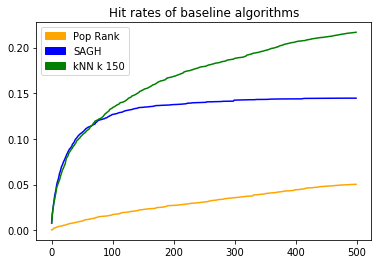

In [0]:
def plot_c_baseline_hit_rates(n=500):
  plt.plot(c_pop_rank_hit_rates[:n], color="orange")
  plt.plot(c_sagh_hit_rates[:n], color="blue")
  plt.plot(c_knn150_hit_rates[:n], color="green")

  orange_patch = mpatches.Patch(color="orange", label="Pop Rank")
  blue_patch = mpatches.Patch(color="blue", label="SAGH")
  green_patch = mpatches.Patch(color="green", label="kNN k 150")
  patches = [orange_patch, blue_patch, green_patch]
  plt.legend(handles=patches)

  plt.title("Hit rates of baseline algorithms")

plot_c_baseline_hit_rates();

# Factorization machines

Now we want to evaluate the actual algorithms of interest - factorization machines. We will use the following variants.

*  (Adjusted) Pairwise factorization machines
*  (Adjusted pairwise) TransRec factorization machines
*  (Adjusted pairwise) Field-aware factorization machines

All variants use BPR (Bayesian Personalized Ranking) loss, AdaBatch reconditioning and the AdaGrad optimizer.

**Regarding reproducibility - Scores of own runs might not match exactly**

Seeds are used at all identified places where randomness is used (sampling of negative examples, latent factor initialization), but there still seem to be reproducibility issues because of non-deterministic TensorFlow GPU operations (possibly related to https://github.com/tensorflow/tensorflow/issues/2732) and no use of locking (which could be addressed at possible small runtime costs but was not since we have reproducibility issues anyway).

## Implementation

### Features

In [0]:
def _df2col_val(df, col_name, col_vals, with_first_unknown,
                with_unknown_ignored):
  col = df[col_name].to_numpy()

  if with_first_unknown:
    col = np.insert(col, 0, 0)

  if col_name in col_vals:
    val = np.full(len(col), col_vals[col_name])
  else:
    val = np.ones(len(col))
  
  if with_unknown_ignored:
    val[col == 0] = 0.0

  return col, val


def _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals,
            with_first_unknown, with_unknown_ignored):

  col_csrs = []
  for col_name, col_num in zip(col_names, col_nums):
    col, val = _df2col_val(df, col_name, col_vals, with_first_unknown,
                           with_unknown_ignored)
    col_csr = csr_matrix((val, (maincol, col)), shape=(maincol_num, col_num))
    col_csrs.append(col_csr)

  return sp.hstack(col_csrs, format="csr")


def _df2ctx_csr(df, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are ignored
  as the number of context features does not influence ranking.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_interactions, num_ctx_feats]
  """
  maincol_num = len(df)
  maincol = np.arange(maincol_num, dtype=int)
  return _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals, False,
                 True)


def _df2user_csr(df, usercol_name, usercol_num, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the per-user concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are ignored
  as the number of user features does not influence ranking.
  The unknown user (row 0) has no features.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_users, num_user_feats]
  """
  df = df[col_names].drop_duplicates().sort_values(usercol_name)
  usercol, _ = _df2col_val(df, usercol_name, col_vals, True, True)
  return _df2csr(df, usercol, usercol_num, col_names, col_nums, col_vals, True,
                 True)


def _df2item_csr(df, maincol_name, maincol_num, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the per-item concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are set
  as the number of item features influences ranking.
  The unknown item (row 0) has all unknown feature.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_items, num_item_feats]
  """
  df = df[col_names].drop_duplicates().sort_values(maincol_name)
  maincol, _ = _df2col_val(df, maincol_name, col_vals, True, False)
  return _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals, True,
                 False)


def _meta_df2num(meta_df, col_name):
  return meta_df[col_name].max() + 1


def _item2col(meta_df, col_name):
  item2col = meta_df[["traid", col_name]].drop_duplicates()
  item2col = item2col.sort_values("traid")[col_name].to_numpy()
  item2col = np.insert(item2col, 0, 0)  # unknown column
  return item2col


def _df2encoded_user_csr(seeds_df, meta_df, ucol_name, ucol_num, icol_name,
                         icol_num, col_names, col_nums, col_vals,
                         normalize_fn):

  ui_df = seeds_df[[ucol_name, icol_name]].drop_duplicates()
  ui_df = ui_df.sort_values([ucol_name, icol_name]).reset_index(drop=True)

  ucol, _ = _df2col_val(ui_df, ucol_name, col_vals, True, True)

  # use weighting of user column for individual item columns
  if ucol_name in col_vals:
    icol_vals = {icol_name: col_vals[icol_name]}
  else:
    icol_vals = dict()
  icol, val = _df2col_val(ui_df, icol_name, icol_vals, True, True)

  # normalize weighting of individual item columns
  val = val * normalize_fn(ui_df, meta_df, ucol_name, icol_name)
  
  col_csrs = [csr_matrix((val, (ucol, icol)), shape=(ucol_num, icol_num))]

  if col_names:
    seeds_df = seeds_df[col_names + [ucol_name]].drop_duplicates().sort_values(ucol_name)
    ucol, _ = _df2col_val(seeds_df, ucol_name, col_vals, True, True)

    for col_name, col_num in zip(col_names, col_nums):
      col, val = _df2col_val(seeds_df, col_name, col_vals, True, True)
      col_csr = csr_matrix((val, (ucol, col)), shape=(ucol_num, col_num))
      col_csrs.append(col_csr)

  return sp.hstack(col_csrs, format="csr")

In [0]:
def df2usersitems(df, meta_df, seeds_df=None):
  """
  Function for only using user and item index features.

  Returns a tuple of
   * number of users including unknown user
   * user indices array of shape                [num_interactions]
   * user features csr matrix of dense shape    [num_users, num_user_feats]
   * number of items including unknown item
   * item indices array of shape                [num_interactions]
   * item features csr matrix of dense shape    [num_items, num_item_feats]
   * context features csr matrix of dense shape [num_interactions, num_ctx_feats]
   * array of artists per item indices of shape [num_items]
   * array of albums per item indices of shape  [num_items]
  """

  num_users = _meta_df2num(meta_df, "pid")
  num_items = _meta_df2num(meta_df, "traid")

  item2artist = _item2col(meta_df, "artid")
  item2album = _item2col(meta_df, "albid")

  user_feats = sp.identity(num_users, format="csr")
  item_feats = sp.identity(num_items, format="csr")
  
  user_indices = df["pid"].to_numpy()
  item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
  ctx_feats = None

  return (num_users, user_indices, user_feats, num_items, item_indices,
          item_feats, ctx_feats, item2artist, item2album)


def df2usersitemfeats(col_vals=dict()):
  """
  Function for using user index and item index, album and artist features.
  """
  def _df2usersitemfeats(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2usersitemfeats


def df2all(col_vals=dict()):
  """
  Function for using all features, excluding previous item context features.
   * user features: pid, userid, age, country, gender
   * item features: traid, albid, artid
  """
  def _df2all(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_b_ages = _meta_df2num(meta_df, "b_age")
    num_countries = _meta_df2num(meta_df, "country")
    num_genders = _meta_df2num(meta_df, "gender")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "b_age", "country", "gender"]
    user_col_nums = [num_users, num_true_users, num_b_ages, num_countries,
                     num_genders]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2all


def df2usersprevitems(col_vals=dict()):
  """
  Function for only using user, item and previous item index features.
  """
  def _df2usersprevitems(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")
    item_feats = sp.identity(num_items, format="csr")
    
    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = _df2ctx_csr(df, ["prev_traid"], [num_items], col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2usersprevitems


def df2usersprevitemfeats(col_vals=dict()):
  """
  Function for using user index and item index, album and artist features,
  as well as previous item index, album and artist features.
  """
  def _df2usersprevitemfeats(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"),
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None

    ctx_cols = ["prev_traid", "prev_albid", "prev_artid"]
    ctx_col_nums = [num_items, num_albums, num_artists]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2usersprevitemfeats


def df2prevall(col_vals=dict()):
  """
  Function for using all features.
   * user features: pid, userid, age, country, gender
   * item features: traid, albid, artid
   * context features: prev_traid, prev_albid, prev_artid
  """
  def _df2prevall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_b_ages = _meta_df2num(meta_df, "b_age")
    num_countries = _meta_df2num(meta_df, "country")
    num_genders = _meta_df2num(meta_df, "gender")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"),
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "b_age", "country", "gender"]
    user_col_nums = [num_users, num_true_users, num_b_ages, num_countries,
                     num_genders]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None

    ctx_cols = ["prev_traid", "prev_albid", "prev_artid"]
    ctx_col_nums = [num_items, num_albums, num_artists]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2prevall

In [0]:
def equi_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_equi_weights(g):
    g["weight"] = 1.0 / g.size
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_equi_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights


def sqrt_equi_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_sqrt_equi_weights(g):
    g["weight"] = 1.0 / sqrt(g.size)
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_sqrt_equi_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights


def sqrt_popularity_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_sqrt_popularity_weights(g):
    g["weight"] = g["weight"] / g["weight"].sum()
    return g

  item_weights = 1.0 / meta_df.groupby(icol_name).size().apply(np.sqrt)
  item_weights = item_weights.rename("weight")
  ui_df = ui_df.join(item_weights, on=icol_name)
  ui_df = ui_df.groupby(ucol_name).apply(_group_sqrt_popularity_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights


def one_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_one_weights(g):
    g["weight"] = 1.0
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_one_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights

In [0]:
def df2encodedusersitems(col_vals=dict(),
                         encode_fn=sqrt_equi_weight_normalize):
  """
  Function for only using item index features,
  representing users as their items.
  """
  def _df2encodedusersitems(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, [], [], col_vals,
                                        encode_fn)
    else:
      user_feats = None

    item_feats = sp.identity(num_items, format="csr")

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersitems


def df2encodedusersall(col_vals=dict(),
                       encode_fn=sqrt_equi_weight_normalize):
  """
  Function for using all features, representing users as their items:
   * user features: playlist items, userid, age, country, gender
   * item features: traid, albid, artid
  """
  def _df2encodedusersall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_b_ages = _meta_df2num(meta_df, "b_age")
    num_countries = _meta_df2num(meta_df, "country")
    num_genders = _meta_df2num(meta_df, "gender")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"),
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_cols = ["userid", "b_age", "country", "gender"]
      user_col_nums = [num_true_users, num_b_ages, num_countries, num_genders]
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, user_cols,
                                        user_col_nums, col_vals, encode_fn)
    else:
      user_feats = None
      
    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    
    ctx_feats = None
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersall


def df2encodedusersprevall(col_vals=dict(),
                           encode_fn=sqrt_equi_weight_normalize):
  """
  Function for using all features including previous,
  representing users as their items:
   * user features: playlist items, userid, age, country, gender
   * item features: traid, albid, artid
   * context features: prev_traid, prev_albid, prev_artid
  """
  def _df2encodedusersprevall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_b_ages = _meta_df2num(meta_df, "b_age")
    num_countries = _meta_df2num(meta_df, "country")
    num_genders = _meta_df2num(meta_df, "gender")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"),
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_cols = ["userid", "b_age", "country", "gender"]
      user_col_nums = [num_true_users, num_b_ages, num_countries, num_genders]
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, user_cols,
                                        user_col_nums, col_vals, encode_fn)
    else:
      user_feats = None
      
    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    
    ctx_cols = ["prev_traid", "prev_albid", "prev_artid"]
    ctx_col_nums = [num_items, num_albums, num_artists]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersprevall

### Sampling

Different methods for sampling negative examples can be used.

We use implementations of the different methods defined in my master's thesis in section **3.6 Sampling negative feedback**.

The implementations are functions with the same signature which can be set as function parameters.

In [0]:
"""
We can't use a njit generator inside a njit generator,
because of nested generator memory leak
https://github.com/numba/numba/issues/3451
https://github.com/numba/numba/issues/1807
"""


@nb.njit()
def _nb_a2bs(as_, num_as, bs):
  a2bs_mapping = [{-1, -2} for _ in range(num_as)]  # -1, -2 as dummy for type inference
  for i in range(as_.size):
    a2bs_mapping[as_[i]].add(bs[i])
  return a2bs_mapping


@nb.njit()
def _nb_rand_choice(arr, size, probs):
    return arr[np.searchsorted(np.cumsum(probs), np.random.random(size))]


distribution_nb_spec = [
 ("num_users", nb.int64),
 ("num_items", nb.int64),
 ("user_indices", nb.int64[:]),
 ("item_indices", nb.int64[:]),
 ("items", nb.optional(nb.int64[:])),
 ("rho", nb.optional(nb.float64))
]
class DistributionNb():
  def __init__(self, num_users, num_items, user_indices, item_indices, seed,
               items, rho):
    self.num_users = num_users
    self.num_items = num_items
    self.user_indices = user_indices
    self.item_indices = item_indices
    np.random.seed(seed)
    self.items = items
    self.rho = rho

  def samples(self, size):
    return None


@nb.jitclass(distribution_nb_spec)
class UniformDistributionNb(DistributionNb):
  def samples(self, size):
    return np.random.randint(0, self.num_items, size=size)


@nb.jitclass(distribution_nb_spec)
class InstanceDistributionNb(DistributionNb):
  def samples(self, size):
    return np.random.choice(self.item_indices, size=size)


@nb.jitclass(distribution_nb_spec)
class _ExpDistributionNb(DistributionNb):
  def samples(self, size):
    # inverse transformation sampling from truncated exponential distribution
    rand = np.random.rand(size) * (1.0 - np.exp(-1.0 / self.rho))
    sample_indices = -self.num_items * self.rho * np.log(1.0 - rand)
    sample_indices = sample_indices.astype(np.int64)
    return self.items[sample_indices]


def exp_distribution_nb(rho=1.0):
  def _exp_distribution_nb(num_users, num_items, user_indices, item_indices,
                           seed, items_none, rho_none):
    # item indices sorted by count
    items, counts = np.unique(item_indices, return_counts=True)
    items = np.concatenate((items[np.argsort(-counts)], [0]))  # unknown item
    return _ExpDistributionNb(num_users, num_items, user_indices, item_indices,
                              seed, items, rho)
                              
  return _exp_distribution_nb


accepter_nb_spec = [
 ("num_users", nb.int64),
 ("num_items", nb.int64),
 ("user_indices", nb.int64[:]),
 ("item_indices", nb.int64[:]),
 ("item2artist", nb.int64[:]),
 ("item2album", nb.int64[:])
]
class AccepterNb():
  def __init__(self, num_users, num_items, user_indices, item_indices,
               item2artist, item2album):
    self.num_users = num_users
    self.num_items = num_items
    self.user_indices = user_indices
    self.item_indices = item_indices
    self.item2artist = item2artist
    self.item2album = item2album

  def item2(self):
    return None

  def user2(self):
    if self.item2() is not None:
      return _nb_a2bs(self.user_indices, self.num_users,
                      self.item2()[self.item_indices])
    else:
      return None


@nb.njit(nb.optional(nb.int64[:])())
def _nb_none_intarray():
  return None


@nb.jitclass(accepter_nb_spec)
class AllAccepterNb(AccepterNb):
  def item2(self):
    return _nb_none_intarray()


@nb.jitclass(accepter_nb_spec)
class TrackAccepterNb(AccepterNb):
  def item2(self):
    return np.arange(0, self.num_items)


@nb.jitclass(accepter_nb_spec)
class ArtistAccepterNb(AccepterNb):
  def item2(self):
    return self.item2artist


@nb.jitclass(accepter_nb_spec)
class AlbumAccepterNb(AccepterNb):
  def item2(self):
    return self.item2album


@nb.njit()
def _nb_take_wrap(array, start, end):
  if end <= len(array):
    return array[start:end]
  else:
    modulo_end = end % len(array)
    return np.concatenate((array[start:end], array[:modulo_end]))


@nb.njit()
def _nb_sampler(dist, accepter, epochs, batch_size, num_users, num_items,
                user_indices, item_indices, seed):

  user2accs = accepter.user2()
  item2acc = accepter.item2()

  epoch_size = len(user_indices)
  batches_per_epoch = int(ceil(epoch_size / batch_size))
  epoch_batches_size = batches_per_epoch * batch_size

  interaction_mask = np.arange(0, epoch_size)

  for e in range(epochs):
    np.random.shuffle(interaction_mask)

    neg = dist.samples(epoch_batches_size)
    extra_neg = dist.samples(epoch_batches_size)
    j = 0

    for b in range(batches_per_epoch):
      # batching
      b_start = b * batch_size
      b_end = b_start + batch_size
      b_int_mask = _nb_take_wrap(interaction_mask, b_start, b_end)
      b_neg = neg[b_start:b_end]

      # negative sample acceptance
      if user2accs is not None:
        for i in range(batch_size):
          while item2acc[b_neg[i]] in user2accs[user_indices[b_int_mask[i]]]:
            b_neg[i] = extra_neg[j]
            j += 1
            if j == epoch_batches_size:
              # continue with new samples
              extra_neg = dist.samples(epoch_batches_size)
              j = 0
      
      yield b_int_mask, b_neg


def create_sampler(dist, accepter):
  def _sampler(epochs, batch_size, num_users, num_items,
               user_indices, item_indices, item2artist, item2album, seed=1):
    """
    Create a generator of batches
    of interaction indices and corresponding negative item indices
    using the supplied distribution and accepter.
    """
    _dist = dist(num_users, num_items, user_indices, item_indices, seed,
                 None, None)
    _accepter = accepter(num_users, num_items, user_indices, item_indices,
                         item2artist, item2album)
    return _nb_sampler(_dist, _accepter, epochs, batch_size,
                       num_users, num_items, user_indices, item_indices, seed)

  return _sampler


# Uniform samplers
uniform_sampler = create_sampler(UniformDistributionNb, AllAccepterNb)
accepted_uniform_sampler = create_sampler(UniformDistributionNb, TrackAccepterNb)
accepted_artist_uniform_sampler = create_sampler(UniformDistributionNb, ArtistAccepterNb)
accepted_album_uniform_sampler = create_sampler(UniformDistributionNb, AlbumAccepterNb)

# Instance samplers
instance_sampler = create_sampler(InstanceDistributionNb, AllAccepterNb)
accepted_instance_sampler = create_sampler(InstanceDistributionNb, TrackAccepterNb)
accepted_artist_instance_sampler = create_sampler(InstanceDistributionNb, ArtistAccepterNb)
accepted_album_instance_sampler = create_sampler(InstanceDistributionNb, AlbumAccepterNb)

# Exp samplers
exp_sampler = create_sampler(exp_distribution_nb(), AllAccepterNb)
accepted_exp_sampler = create_sampler(exp_distribution_nb(), TrackAccepterNb)
accepted_artist_exp_sampler = create_sampler(exp_distribution_nb(), ArtistAccepterNb)
accepted_album_exp_sampler = create_sampler(exp_distribution_nb(), AlbumAccepterNb)

In [0]:
@nb.njit()
def _nb_crossbatch_sampler(dist, accepter, epochs, batch_size,
                           num_users, num_items, user_indices, item_indices,
                           seed):

  user2accs = accepter.user2()
  user2accs_np = [np.unique(np.array(list(s)))[2:] for s in user2accs]
  user2accs_np_max = np.max(np.array([len(l) for l in user2accs_np]))
  item2acc = accepter.item2()

  epoch_size = len(user_indices)
  batches_per_epoch = int(ceil(epoch_size / batch_size))
  epoch_batches_size = batches_per_epoch * batch_size

  interaction_mask = np.arange(0, epoch_size)

  for e in range(epochs):
    np.random.shuffle(interaction_mask)

    neg = dist.samples(epoch_batches_size)
    extra_neg = dist.samples(epoch_batches_size)
    j = 0

    for b in range(batches_per_epoch):
      # batching
      b_start = b * batch_size
      b_end = b_start + batch_size
      b_int_mask = _nb_take_wrap(interaction_mask, b_start, b_end)
      b_neg = neg[b_start:b_end]

      # negative sample acceptance
      if user2accs is not None:
        for i in range(batch_size):
          while item2acc[b_neg[i]] in user2accs[user_indices[b_int_mask[i]]]:
            b_neg[i] = extra_neg[j]
            j += 1
            if j == epoch_batches_size:
              # continue with new samples
              extra_neg = dist.samples(epoch_batches_size)
              j = 0

      # === non-acceptance indexing ===

      # will be filled with non-acceptance indices
      b_u_indices = np.zeros(batch_size * user2accs_np_max, dtype=nb.int64)
      b_i_indices = np.zeros(batch_size * user2accs_np_max, dtype=nb.int64)

      # sorted negative item non-acceptance indices
      i_acc = item2acc[b_neg]
      i_acc_mask = np.argsort(i_acc)
      inverse_i_acc_mask = np.argsort(i_acc_mask)
      i_acc = i_acc[i_acc_mask]

      b_users = user_indices[b_int_mask]
      k = 0
      for bui, b_user in enumerate(b_users):
        # sorted item non-acceptance indices for user b_user at batch index bui
        u_acc = user2accs_np[b_user]
        len_u_acc = len(u_acc)

        # go through sorted negative (i_acc) and user (u_acc)
        # item non-acceptance indices in parallel
        # to find non-accepted batch interactions (bui, bii)
        bii = 0
        j = 0
        while bii < batch_size and j < len_u_acc:
          if i_acc[bii] < u_acc[j]:
            bii += 1
          elif i_acc[bii] > u_acc[j]:
            j += 1
          else:
            b_u_indices[k] = bui
            # fill with original batch index
            b_i_indices[k] = inverse_i_acc_mask[bii]  
            bii += 1
            j += 1
            k += 1

      # ===                         ===

      yield b_int_mask, b_neg, b_u_indices[:k], b_i_indices[:k]


def create_crossbatch_sampler(dist, accepter):
  def _sampler(epochs, batch_size, num_users, num_items,
               user_indices, item_indices, item2artist, item2album, seed=1):
    """
    Return a generator of batches of
     * interaction indices and corresponding negative item indices
     * indices of non-accepted batch cross interactions between those
    
    The non-acceptance indices correspond to a coo matrix of dense shape
    [batch_size, batch_size] and are NOT sorted! They will have to be sorted in
    TensorFlow using tf.sparse.reorder.

    Negative items are chosen from a uniform distribution without replacement,
    so no duplicate negative items occur in a batch.
    
    For accepting items the supplied accepter is used    
    """
    _dist = dist(num_users, num_items, user_indices, item_indices, seed,
                 None, None)
    _accepter = accepter(num_users, num_items, user_indices, item_indices,
                         item2artist, item2album)
    return _nb_crossbatch_sampler(_dist, _accepter, epochs, batch_size,
                                  num_users, num_items,
                                  user_indices, item_indices, seed)

  return _sampler


# Cross-batch samplers
accepted_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, TrackAccepterNb)
accepted_artist_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, ArtistAccepterNb)
accepted_album_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, AlbumAccepterNb)

### TensorFlow

In [0]:
class FMArgs():
  """
  Arguments for extended pairwise factorization machine
  """

  def __init__(self,
               epoch_size,
               epochs=1000,
               batch_size=16384,
               num_dims=50,
               init_mean=0.1,
               linear_reg=0.01,
               factors_reg=0.01,
               lr=0.1,
               eval_freq=10):
      """
      :param epoch_size: Epoch size
      :param epochs: Number of epochs to run
      :param batch_size: Mini-batch size
      :param num_dims: Model dimensionality
      :param init_mean: Initialization mean for model weights
      :param linear_reg: Regularization rate for linear weights
      :param factors_reg: Regularization rate for factor weights
      :param lr: Adagrad learning rate
      :param incr_lr: Percentual increase of the learning over epochs
                      (1% = 0.01) 
      :param eval_freq: Frequency at which to evaluate model
      """
      self.epochs = epochs
      self.batch_size = batch_size
      self.batches_per_epoch = int(ceil(epoch_size / batch_size))
      self.num_dims = num_dims
      self.init_mean = init_mean
      self.linear_reg = linear_reg
      self.factors_reg = factors_reg
      self.lr = lr
      self.eval_freq = eval_freq


class TfFM:
  """
  Extended pairwise factorization machine
  """

  def __init__(self, graph, train_dataset, val_dataset, args, top_n):
    
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.args = args
    self.top_n = top_n
    
    self.sess = tf.Session(graph=graph)
    with self.sess.graph.as_default():
      tf.set_random_seed(1)
      (self.handle, self.pred_top_op, self.loss_op, self.train_op,
       self.val_op) =  self._create_model(val_dataset, args, top_n)

  def _create_vars(self, args, val_dataset):
    feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_factors = tf.random_uniform_initializer(-args.init_mean,
                                                        args.init_mean, seed=2)
    
    var_linear = tf.Variable(initializer_linear([feat_dim, 1]), name="linear")
    var_factors = tf.Variable(initializer_factors([feat_dim, args.num_dims]),
                              name="factors")
    
    return var_linear, var_factors

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, feat_shape, feat_shape, na_shape, indices_shape)
  
  def safe_sparse_dense_matmul(self, batch, var):
    """
    Method which can be overwritten to provide a safe version of 
    sparse_dense_matmul for cases where the number of dimensions or
    the sparse matrix are too large (args.num_dims * nnz(batch) > 2^31).
    
    This may occur when recommending the top n items for each user
    which is encoded through its items, because then 
     * the batch / sparse matrix contains a query instance for all items
     * this query instance is large

    See also https://github.com/tensorflow/tensorflow/issues/25971
    """
    return tf.sparse.sparse_dense_matmul(batch, var)

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    var_linear, var_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    ctx_sum = self.safe_sparse_dense_matmul(ctx_batch, var_factors)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)

      # Interaction term
      i_sum = self.safe_sparse_dense_matmul(item_batch, var_factors)
      interaction = tf.multiply(i_sum, ctx_sum)
      interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_pred_top_op(self, pred_batch, idx_batch, n):
    scores, indices = tf.math.top_k(tf.squeeze(pred_batch), k=n)
    item_indices = tf.gather(idx_batch, indices)
    return scores, item_indices

  def _create_utility_op(self, pos_preds, neg_preds, na_batch):
    return pos_preds - neg_preds

  def _create_loss_op(self, gz, args):
    # BPR loss op (add 1e-10 to help with numerical stability)
    return -tf.reduce_sum(tf.log(1e-10 + tf.sigmoid(gz)))

  def _create_l2_reg_grad(self, var, reg):
    return reg * var

  def _create_reg_grad(self, var, grad, args):
    if "linear" in var.name:
      return self._create_l2_reg_grad(var, args.linear_reg)
    else:
      return self._create_l2_reg_grad(var, args.factors_reg)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = tfs.add(to_indicator(ctx_batch), to_indicator(pos_batch))
    nz_batch = tfs.add(nz_batch, to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)

    grads_and_vars = [(tf.multiply(nz_lr, grad), var) for grad, var
                      in grads_and_vars]

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])


  def _create_val_op(self, gz):
    auc_op = tf.cast(tf.squeeze(gz > 0), tf.float32)
    return tf.reduce_mean(auc_op)

  def _create_model(self, val_dataset, args, top_n):
    # Model variables
    vars_ = self._create_vars(args, val_dataset)

    # Batch iterator from data sets, handle decides data set to use
    handle = tf.placeholder(tf.string, shape=[])
    batch_iter = tf.data.Iterator.from_string_handle(
        handle,
        val_dataset.output_types,
        self._create_shape(val_dataset),
        val_dataset.output_classes)
    
    batches_ = batch_iter.get_next()
    idx_batch = batches_[-1]
    na_batch = batches_[-2]
    batches_ = batches_[:-2]
    
    # Prediction op
    pos_preds, neg_preds = self._create_pred_ops(vars_, batches_, args,
                                                 val_dataset)
    
    # Utility op
    gz = self._create_utility_op(pos_preds, neg_preds, na_batch)

    # Top n items prediction op
    preds_top = self._create_pred_top_op(pos_preds, idx_batch, top_n)
    
    # Loss op
    loss_op = self._create_loss_op(gz, args)
    
    # Training op
    train_op = self._create_train_op(loss_op, vars_, batches_, args)
    
    # Validation op
    val_op = self._create_val_op(gz)
    
    return (handle, preds_top, loss_op, train_op, val_op)

  def train(self, save_epochs=[], save_epoch_paths=[]):
    with self.sess.graph.as_default():
      
      # Initialization
      self.sess.run(tf.global_variables_initializer())

      train_iter = self.train_dataset.make_initializable_iterator()
      val_iter = self.val_dataset.make_one_shot_iterator()

      self.sess.run(train_iter.initializer)
      
      train_handle = self.sess.run(train_iter.string_handle())
      val_handle = self.sess.run(val_iter.string_handle())

      # Training scores
      best_auc_epoch = 0
      best_val_auc = -1
      best_rank_epoch = 0
      best_val_rank = self.args.batch_size

      losses = []
      val_losses = []
      val_aucs = []
      val_ranks = []

      # Training loop
      for epoch in range(1, self.args.epochs + 1):
        print("Epoch: {}".format(epoch))

        loss = 0
        for _ in range(self.args.batches_per_epoch):
          loss, _ = self.sess.run([self.loss_op, self.train_op],
                                  feed_dict={self.handle: train_handle})

        losses.append(loss)
        print("\tLast batch loss = {}".format(loss))

        if epoch == 1 or epoch % self.args.eval_freq == 0:
          val_loss, val_scores = self.sess.run([self.loss_op, self.val_op],
                                              feed_dict={self.handle: val_handle})

          if isinstance(val_scores, tuple):
            val_auc, val_rank = val_scores
          else:
            val_auc = val_scores
            val_rank = None

          val_losses.append(val_loss)
          val_aucs.append(val_auc)
          print("\tVal loss = " + str(val_loss))
          print("\tVal AUC = " + str(val_auc))
          
          if val_rank:
            val_ranks.append(val_rank)
            print("\tVal Rank = " + str(val_rank))

          if val_auc > best_val_auc:
            best_auc_epoch = epoch
            best_val_auc = val_auc

          print("\tCurrent max AUC = {} at epoch {}"
                .format(str(best_val_auc), best_auc_epoch))

          if val_rank:
            if val_rank < best_val_rank:
              best_rank_epoch = epoch
              best_val_rank = val_rank

            print("\tCurrent min Rank = {} at epoch {}"
                  .format(str(best_val_rank), best_rank_epoch))

        if epoch in save_epochs:
          save_path = save_epoch_paths[save_epochs.index(epoch)]
          self.save(save_path)
          print("\tSaved to = {}".format(save_path))

      # Closing iterator
      try:
        while True:
          self.sess.run(self.loss_op, feed_dict={self.handle: train_handle})
      except tf.errors.OutOfRangeError:
        pass
          
      return losses, val_losses, val_aucs

  def predict(self, query_dataset):
    with self.sess.graph.as_default():
      
      query_iter = query_dataset.make_one_shot_iterator()
      query_handle = self.sess.run(query_iter.string_handle())
      
      scores_arr = []
      indices_arr = []
      try:
        while True:
          scores, indices = self.sess.run(self.pred_top_op,
                                          feed_dict={self.handle: query_handle})
          scores_arr.append(scores)
          indices_arr.append(indices)
      except tf.errors.OutOfRangeError:
        pass
      
      return np.concatenate(scores_arr), np.concatenate(indices_arr)

  def save(self, save_path):
    with self.sess.graph.as_default():
      saver = tf.train.Saver()
      saver.save(self.sess, save_path)

  def load(self, load_path):
    with self.sess.graph.as_default():
      saver = tf.train.Saver()
      saver.restore(self.sess, load_path)
  
  def close(self):
    self.sess.close()

In [0]:
class TfBatchFM(TfFM):
  """
  Extended pairwise factorization machine with cross-batch sampling
  """

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    var_linear, var_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    ctx_sum = self.safe_sparse_dense_matmul(ctx_batch, var_factors)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Interaction term
      i_sum = self.safe_sparse_dense_matmul(item_batch, var_factors)
      if shared:
        interaction = tf.matmul(ctx_sum, i_sum, transpose_b=True)
      else:
        interaction = tf.multiply(i_sum, ctx_sum)
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

  def _create_utility_op(self, pos_preds, neg_preds, na_batch):
    # eliminate non-accepted negatives
    gz = pos_preds - neg_preds 
    na_gz = tfs.reorder(na_batch)  # sorted indices not guaranteed
    na_gz = tfs.to_dense(na_gz, default_value=False)
    na_gz = tf.cast(na_gz, tf.float32)
    na_gz = tf.multiply(gz, na_gz)
    return gz - na_gz

  def _create_loss_op(self, gz, args):
    # BPR loss op (add 1e-10 to help with numerical stability)
    bprloss_op = tf.log(1e-10 + tf.sigmoid(gz))
    bprloss_op = tf.reduce_mean(bprloss_op, axis=1)
    bprloss_op = tf.reduce_sum(bprloss_op)
    return -bprloss_op

  def _create_val_op(self, gz):
    # AUC op
    auc_gz = tf.expand_dims(tf.linalg.diag_part(gz), 1)
    auc_op = super(TfBatchFM, self)._create_val_op(auc_gz)
    
    # Rank op
    rank_op = tf.cast(gz < 0, tf.float32)
    rank_op = tf.reduce_sum(rank_op, axis=1)
    rank_op = tf.reduce_mean(rank_op)

    return (auc_op, rank_op)

In [0]:
class TfVanillaFM(TfFM):
  """
  Vanilla factorization machine
  """

  def _create_vars(self, args, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]
    cat_feat_dim = feat_dim + item_feat_dim

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_factors = tf.random_uniform_initializer(-args.init_mean,
                                                        args.init_mean, seed=2)
    
    var_linear = tf.Variable(initializer_linear([cat_feat_dim, 1]),
                             name="linear")
    var_factors = tf.Variable(initializer_factors([cat_feat_dim, args.num_dims]),
                              name="factors")
    
    return var_linear, var_factors

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[1][1]
    item_feat_dim = val_dataset.output_shapes[2][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, na_shape, indices_shape)

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    ctx_batch, pos_batch, neg_batch = batches_
    var_linear, var_factors = vars_

    sq_factors = tf.square(var_factors)

    def _create_pred_op(item_batch):
      batch = tfs.concat(1, [ctx_batch, item_batch])

      # Linear term
      linear = tfs.sparse_dense_matmul(batch, var_linear)

      # Interaction term
      term_1 = tfs.sparse_dense_matmul(batch, var_factors)
      term_1 = tf.reduce_sum(tf.square(term_1), axis=1, keepdims=True)
      term_2 = tfs.sparse_dense_matmul(tf.square(batch), sq_factors)
      term_2 = tf.reduce_sum(term_2, axis=1, keepdims=True)
      interaction = 0.5 * (term_1 - term_2)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)
  
  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = tfs.add(to_indicator(pos_batch), to_indicator(neg_batch))
    nz_batch = to_indicator(tfs.concat(1, [ctx_batch, nz_batch]))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)

    grads_and_vars = [(tf.multiply(nz_lr, grad), var) for grad, var
                      in grads_and_vars]

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TransRecFMArgs(FMArgs):
  """
  Arguments for TransRec factorization machines
  """
  
  def __init__(self, epoch_size, max_norm=1.0, **kwargs):
    """
    :param epoch_size: Epoch size
    :param max_norm: Maximum norm over the model dimensionality,
                     None or zero means no norm clipping
    """
    super(TransRecFMArgs, self).__init__(epoch_size, **kwargs)
    self.max_norm = max_norm


class TfTransRecFM(TfFM):
  """
  TransRec factorization machine
  """

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, item_feat_shape, 
            na_shape, indices_shape)

  def _create_vars(self, args, val_dataset):
    ctx_feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_ctx_factors = tf.random_uniform_initializer(-args.init_mean,
                                                            args.init_mean,
                                                            seed=2)
    initializer_item_factors = tf.random_uniform_initializer(-args.init_mean,
                                                             args.init_mean,
                                                             seed=3)
    
    var_linear = tf.Variable(
        initializer_linear([item_feat_dim, 1]), name="linear")
    
    var_ctx_shape = [ctx_feat_dim, args.num_dims]
    var_ctx_factors = tf.Variable(
        initializer_ctx_factors(var_ctx_shape), name="ctx_factors")
    
    var_item_shape = [item_feat_dim, args.num_dims]
    var_item_factors = tf.Variable(
        initializer_item_factors(var_item_shape), name="item_factors")
    
    return var_linear, var_ctx_factors, var_item_factors

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_

    # Common context terms
    c_factors_sum = self.safe_sparse_dense_matmul(
        ctx_batch, var_ctx_factors) + self.safe_sparse_dense_matmul(
            prev_batch, var_item_factors)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)

      # Item terms
      i_factors_sum = self.safe_sparse_dense_matmul(
          item_batch, var_item_factors)

      # Actual interaction terms
      term_1 = tf.square(c_factors_sum)
      term_2 = tf.multiply(c_factors_sum, i_factors_sum)
      term_3 = tf.square(i_factors_sum)

      interaction = term_1 - 2 * term_2 + term_3
      interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear - interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_reg_grad(self, var, grad, args):
    if "linear" in var.name:
      return self._create_l2_reg_grad(var, args.linear_reg)
    else:
      return self._create_l2_reg_grad(var, args.factors_reg)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    
    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_
    
    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    if args.max_norm:
      clip_opt = tf.contrib.opt.VariableClippingOptimizer(
          opt=opt,
          vars_to_clip_dims={var_item_factors: [1]},
          max_norm=args.max_norm)
    else:
      clip_opt = opt
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = to_indicator(ctx_batch)
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[1]
    grads_and_vars[1] = (tf.multiply(nz_lr, grad), var)

    nz_batch = tfs.add(to_indicator(prev_batch), to_indicator(pos_batch))
    nz_batch = tfs.add(nz_batch, to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[0]
    grads_and_vars[0] = (tf.multiply(nz_lr, grad), var)
    grad, var = grads_and_vars[2]
    grads_and_vars[2] = (tf.multiply(nz_lr, grad), var)

    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)

    with self.sess.graph.control_dependencies([train_op]):
      # frequency adaptive regularization op
      reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                      grad,
                                      self._create_reg_grad(var, grad, args)),
                            var) for grad, var in grads_and_vars]
      with opt.avoid_updating_slots():
        reg_op = clip_opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TfBatchTransRecFM(TfTransRecFM, TfBatchFM):
  """
  TransRec factorization machine with cross-batch sampling
  """

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_

    # Common context terms
    c_factors_sum = self.safe_sparse_dense_matmul(
        ctx_batch, var_ctx_factors) + self.safe_sparse_dense_matmul(
            prev_batch, var_item_factors)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Item terms
      i_factors_sum = self.safe_sparse_dense_matmul(
          item_batch, var_item_factors)

      # Actual interaction terms
      if shared:
        term_1 = tf.reduce_sum(tf.square(c_factors_sum), axis=1, keepdims=True)
        term_2 = tf.matmul(c_factors_sum, i_factors_sum, transpose_b=True)
        term_3 = tf.reduce_sum(tf.square(i_factors_sum), axis=1, keepdims=True)
        term_3 = tf.transpose(term_3)
      else:
        term_1 = tf.square(c_factors_sum)
        term_2 = tf.multiply(c_factors_sum, i_factors_sum)
        term_3 = tf.square(i_factors_sum)

      interaction = term_1 - 2 * term_2 + term_3
      if not shared:
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear - interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

In [0]:
class FFMArgs(FMArgs):
  """
  Arguments for extended pairwise field-aware factorization machines
  """
  
  def __init__(self, epoch_size, num_ctx_fields, num_item_fields, **kwargs):
    """
    :param epoch_size: Epoch size
    :param num_ctx_fields: Number of user/context fields
    :param num_item_fields: Number of item fields
    """
    super(FFMArgs, self).__init__(epoch_size, **kwargs)
    self.num_ctx_fields = num_ctx_fields
    self.num_item_fields = num_item_fields
  

class TfFFM(TfFM):
  """
  Extended pairwise field-aware factorization machine


  To illustrate the vectorized implementation, consider the example with
   * user features pid and userid
   * item features traid, albid and artid

  user / context features have shape [user_features, num_item_fields, num_dims]
  item features have shape [item_features, num_user_fields, num_dims]

  Looking up of relevant user / context and item features results in:

  user features of shape [num_user_fields, num_item_fields, num_dims]
  [userid-traid, userid-albid, userid-artid]
  [pid-traid, pid-albid, pid-artid]

  item features of shape [num_item_fields, num_user_fields, num_dims]
  [traid-userid, traid-pid]
  [albid-userid, albid-pid]
  [artid-userid, artid-pid]

  Now transpose item features and multiply element-wise with user features:

  [userid-traid, pid-traid]     [traid-userid, traid-pid]
  [userid-albid, pid-albid]     [albid-userid, albid-pid]
  [userid-artid, pid-artid]     [artid-userid, artid-pid]

  Sum up
  """

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, na_shape, indices_shape)

  def _create_vars(self, args, val_dataset):
    ctx_feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_ctx_factors = tf.random_uniform_initializer(-args.init_mean,
                                                            args.init_mean,
                                                            seed=2)
    initializer_item_factors = tf.random_uniform_initializer(-args.init_mean,
                                                             args.init_mean,
                                                             seed=3)
    
    var_linear = tf.Variable(
        initializer_linear([item_feat_dim, 1]), name="linear")
    
    var_ctx_shape = [ctx_feat_dim, args.num_item_fields, args.num_dims]
    var_ctx_factors = tf.Variable(
        initializer_ctx_factors(var_ctx_shape), name="ctx_factors")
    
    var_item_shape = [item_feat_dim, args.num_ctx_fields, args.num_dims]
    var_item_factors = tf.Variable(
        initializer_item_factors(var_item_shape), name="item_factors")
    
    return var_linear, var_ctx_factors, var_item_factors

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    var_linear, var_ctx_factors, var_item_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    def _create_lookup_op(batch, factors, num_fields):
      batch_feats = tf.slice(batch.indices, [0, 1], [-1, 1])
      batch_feats = tf.reshape(batch_feats, [-1, num_fields])
      batch_vals = tf.reshape(batch.values, [-1, num_fields])
      batch_vals = tf.expand_dims(tf.expand_dims(batch_vals, axis=2), axis=3)
      emb = tf.nn.embedding_lookup(factors, batch_feats)
      emb = tf.multiply(emb, batch_vals)
      return emb

    ctx_emb = _create_lookup_op(ctx_batch, var_ctx_factors, args.num_ctx_fields)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tf.sparse_tensor_dense_matmul(item_batch, var_linear)

      # Interaction term
      item_emb = _create_lookup_op(item_batch, var_item_factors,
                                   args.num_item_fields)
      interaction = tf.multiply(ctx_emb, tf.transpose(item_emb, [0, 2, 1, 3]))
      interaction = tf.reduce_sum(interaction, axis=[1, 2, 3])
      interaction = tf.expand_dims(interaction, axis=1)

      return linear + interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = to_indicator(ctx_batch)
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    nz_lr = tf.expand_dims(nz_lr, 1)
    grad, var = grads_and_vars[1]
    grads_and_vars[1] = (tf.multiply(nz_lr, grad), var)

    nz_batch = tfs.add(to_indicator(pos_batch), to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[0]
    grads_and_vars[0] = (tf.multiply(nz_lr, grad), var)
    nz_lr = tf.expand_dims(nz_lr, 1)
    grad, var = grads_and_vars[2]
    grads_and_vars[2] = (tf.multiply(nz_lr, grad), var)

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TfBatchFFM(TfFFM, TfBatchFM):

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    var_linear, var_ctx_factors, var_item_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    num_fields_multiplied = args.num_ctx_fields * args.num_item_fields

    def _create_lookup_op(batch, factors, num_fields, transpose=False):
      batch_feats = tf.slice(batch.indices, [0, 1], [-1, 1])
      batch_feats = tf.reshape(batch_feats, [-1, num_fields])
      batch_vals = tf.reshape(batch.values, [-1, num_fields])
      batch_vals = tf.expand_dims(tf.expand_dims(batch_vals, axis=2), axis=3)
      emb = tf.nn.embedding_lookup(factors, batch_feats)
      emb = tf.multiply(emb, batch_vals)

      if transpose:
        emb = tf.transpose(emb, [0, 2, 1, 3])
      emb = tf.reshape(emb, [-1, num_fields_multiplied * args.num_dims])

      return emb

    ctx_emb = _create_lookup_op(ctx_batch, var_ctx_factors, args.num_ctx_fields)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Interaction term
      item_emb = _create_lookup_op(item_batch, var_item_factors,
                                   args.num_item_fields, transpose=True)
      if shared:
        interaction = tf.matmul(ctx_emb, item_emb, transpose_b=True)
      else:
        interaction = tf.multiply(item_emb, ctx_emb)
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

In [0]:
class SafeSparseDenseMatmul:
  def safe_sparse_dense_matmul(self, batch, var):
    # perform 10 smaller sparse_dense_matmul and then concat
    var_splits = tf.split(var, 10, axis=1)
    matmul_splits = [tfs.sparse_dense_matmul(batch, v_s) for v_s in var_splits]
    return tf.concat(matmul_splits, axis=1)


class SafeTfFM(SafeSparseDenseMatmul, TfFM):
  pass


class SafeTfBatchFM(SafeSparseDenseMatmul, TfBatchFM):
  pass


class SafeTfTransRecFM(SafeSparseDenseMatmul, TfTransRecFM):
  pass


class SafeTfBatchTransRecFM(SafeSparseDenseMatmul, TfBatchTransRecFM):
  pass

### Wrapper

To use the sampling function, the feature function and the TensorFlow variant implementation combined for evaluation we need to implement wrappers.

First we use wrappers to create batches of train, validation or test instances, using a specific sampling and feature function.

In [0]:
def create_train_batch_generator(epochs, batch_size, df, meta_df, seeds_df,
                                 feature_fn, sampler_fn,
                                 separate_features=False,
                                 item_ctx_features=False):
  """
  Create a training batch generator
  """

  # extract indices and feature mappings from dataframe
  (num_users, user_indices, user_feats, num_items, item_indices, item_feats,
   ctx_feats, item2artist, item2album) = feature_fn(df, meta_df, seeds_df)
  
  # initialize sampler of interactions and negative items
  sampler = sampler_fn(epochs, batch_size, num_users, num_items,
                       user_indices, item_indices, item2artist, item2album)

  # create batches of features from batches of samples
  for l in sampler:
    if len(l) == 4:
      b_pos_mask, b_neg_indices, b_na_indices, b_na_neg_indices = l
      na_ones = np.ones(len(b_na_indices), dtype=bool)
      na_indices = coo_matrix((na_ones, (b_na_indices, b_na_neg_indices)),
                              shape=(batch_size, batch_size))
    else:
      b_pos_mask, b_neg_indices = l
      na_indices = coo_matrix((batch_size, batch_size), dtype=bool)

    b_user_indices = user_indices[b_pos_mask]
    b_pos_indices = item_indices[b_pos_mask]

    user_fs = user_feats[b_user_indices]
    ctx_fs = ctx_feats[b_pos_mask] if ctx_feats is not None else None
    pos_fs = item_feats[b_pos_indices]
    neg_fs = item_feats[b_neg_indices]

    if separate_features and item_ctx_features:
      yield user_fs.tocoo(), ctx_fs.tocoo(), pos_fs.tocoo(), neg_fs.tocoo(), na_indices
    else:
      userctx_fs = sp.hstack([user_fs, ctx_fs])
      if separate_features:
        yield userctx_fs, pos_fs.tocoo(), neg_fs.tocoo(), na_indices
      elif item_ctx_features:
        empty_user_fs = csr_matrix(user_fs.shape)
        pos_fs = sp.hstack([empty_user_fs, pos_fs])
        neg_fs = sp.hstack([empty_user_fs, neg_fs])
        yield userctx_fs, pos_fs, neg_fs, na_indices
      else:
        empty_userctx_fs = csr_matrix(userctx_fs.shape)
        pos_fs = sp.hstack([empty_userctx_fs, pos_fs])
        neg_fs = sp.hstack([empty_userctx_fs, neg_fs])
        userctx_fs._shape = pos_fs.shape
        yield userctx_fs, pos_fs, neg_fs, na_indices


def create_val_batch(batch_size, val_df, meta_df, seeds_df, feature_fn,
                     sampler_fn, separate_features=False,
                     item_ctx_features=False):
  """
  Create a validation batch generator
  """
  repeat = int(ceil(batch_size / len(val_df)))
  epochs = 1
  batch_size = len(val_df) * repeat

  def repeated_feature_fn(df, meta_df, seeds_df):
    (num_users, user_indices, user_feats, num_items, item_indices, item_feats,
     ctx_feats, item2artist, item2album) = feature_fn(df, meta_df, seeds_df)
    
    user_indices = np.repeat(user_indices, repeat)
    item_indices = np.repeat(item_indices, repeat)
    if ctx_feats is not None:
      ctx_feats = ctx_feats.tolil()
      ctx_feats.data = np.repeat(ctx_feats.data, repeat, axis=0)
      ctx_feats.rows = np.repeat(ctx_feats.rows, repeat, axis=0)
      ctx_feats._shape = (ctx_feats.shape[0] * repeat, ctx_feats.shape[1])
      ctx_feats = ctx_feats.tocsr()
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  g = create_train_batch_generator(epochs, batch_size, val_df, meta_df,
                                   seeds_df, repeated_feature_fn, sampler_fn,
                                   separate_features, item_ctx_features)
  
  b = next(g)
  try:
    next(g)
  except StopIteration:
    pass
  
  return b


@nb.njit()
def create_query_items_generator(num_users, user_indices, seed_user_indices,
                                 num_items, seed_item_indices):

  user2items = _nb_a2bs(seed_user_indices, num_users, seed_item_indices)

  for i in range(len(user_indices)):
    user_i = user_indices[i]
    item_indices = np.array([j for j in range(1, num_items)
                             if not bool(j in user2items[user_i])])
    yield i, item_indices
    
  
def create_query_batch_generator(query_df, meta_df, feature_fn,
                                 filter_user_items=False,
                                 separate_features=False,
                                 item_ctx_features=False):
  """
  Create a query batch generator
  """

  # extract user indices and context feature mappings
  # from query context dataframe 
  query_ctx_df = get_query_ctx(query_df)
  (_, user_indices, _, _, _, _, ctx_feats, _,
   _) = feature_fn(query_ctx_df, meta_df)
  
  # extract all indices and other feature mappings
  # from query seeds and meta dataframe
  query_seeds_df = get_query_seeds(query_df)
  (num_users, seed_user_indices, user_feats, num_items, seed_item_indices,
   item_feats, _, _, _) = feature_fn(query_seeds_df, meta_df, query_seeds_df)

  # initialize generator of per-user batches of items
  if filter_user_items:
    g = create_query_items_generator(num_users, user_indices, seed_user_indices,
                                     num_items, seed_item_indices)
  else:
    item_indices = np.arange(num_items)
    g = ((i, item_indices) for i in range(len(user_indices)))

  # create batches of features from per-user batches of items
  for i, item_indices in g: 
    user_fs = user_feats[np.full(len(item_indices), user_indices[i], dtype=int)]
    ctx_fs = ctx_feats[np.full(len(item_indices), i, dtype=int)] if ctx_feats is not None else None
    pos_fs = item_feats[item_indices]

    if separate_features and item_ctx_features:
      yield user_fs.tocoo(), ctx_fs.tocoo(), pos_fs.tocoo(), item_indices
    else:
      userctx_fs = sp.hstack([user_fs, ctx_fs])
      if separate_features:
        yield userctx_fs, pos_fs.tocoo(), item_indices
      elif item_ctx_features:
        empty_user_fs = csr_matrix(user_fs.shape)
        pos_fs = sp.hstack([empty_user_fs, pos_fs])
        yield userctx_fs, pos_fs.tocoo(), item_indices
      else:
        empty_userctx_fs = csr_matrix(userctx_fs.shape)
        pos_fs = sp.hstack([empty_userctx_fs, pos_fs])
        userctx_fs._shape = pos_fs.shape
        yield userctx_fs, pos_fs.tocoo(), item_indices

To use these batches efficiently with the TensorFlow factorization machine implementations, we wrap them as TensorFlow data sets.

In [0]:
def coo2tuple(s, dtype=np.float32):
  s = s.tocoo(copy=False)
  s_indices = np.vstack((s.row.astype(np.int64), s.col.astype(np.int64))).T
  return (s_indices, s.data.astype(dtype), s.shape)


def dummyarray():
  return np.zeros([1], dtype=np.int64)


def dummytuple(dtype=np.float32):
  return (np.zeros([1, 1], dtype=np.int64), np.ones(1, dtype=dtype), [1, 1])


def batch2tuples(b):
  if len(b) == 5:
    # train batch generator with prev batch
    userctx_s, prev_s, pos_s, neg_s, na_s = b
    return (coo2tuple(userctx_s), coo2tuple(prev_s), coo2tuple(pos_s),
            coo2tuple(neg_s), coo2tuple(na_s, dtype=bool), dummyarray())
  elif len(b) == 4:
    if len(b[3].shape) == 2:
      # train batch generator 
      userctx_s, pos_s, neg_s, na_s = b
      return (coo2tuple(userctx_s), coo2tuple(pos_s), coo2tuple(neg_s),
              coo2tuple(na_s, dtype=bool), dummyarray())
    else:
      # query batch generator with prev batch
      userctx_s, prev_s, pos_s, items = b
      return (coo2tuple(userctx_s), coo2tuple(prev_s), coo2tuple(pos_s),
              dummytuple(), dummytuple(dtype=bool), items)
  else:
    # query batch generator
    userctx_s, pos_s, items = b
    return (coo2tuple(userctx_s), coo2tuple(pos_s), dummytuple(),
            dummytuple(dtype=bool), items)


def tuples2tensors(*tuples):
  if len(tuples) == 6:
    userctx, prev, pos, neg, na, items = tuples
    return (tf.SparseTensor(*userctx), tf.SparseTensor(*prev),
            tf.SparseTensor(*pos), tf.SparseTensor(*neg), tf.SparseTensor(*na),
            items)
  else:
    userctx, pos, neg, na, items = tuples
    return (tf.SparseTensor(*userctx), tf.SparseTensor(*pos),
            tf.SparseTensor(*neg), tf.SparseTensor(*na), items)


def batch2dataset(b):
  return tf.data.Dataset.from_tensors(tuples2tensors(*batch2tuples(b)))


def batchgenerator2dataset(g):
  g = (batch2tuples(b) for b in g)
  peek_g = next(g)
  g = itertools.chain([peek_g], g)
  
  f_shape = (tf.int64, tf.float32, tf.int64)
  b_shape = (tf.int64, tf.bool, tf.int64)
  if len(peek_g) == 6:
    g_shape = (f_shape, f_shape, f_shape, f_shape, b_shape, tf.int64)
  else:
    g_shape = (f_shape, f_shape, f_shape, b_shape, tf.int64)
  
  return tf.data.Dataset.from_generator(lambda: g, g_shape).map(tuples2tensors)


def create_train_dataset(epochs, graph, batch_size, df, meta_df, feature_fn,
                         sampler_fn, separate_features=False,
                         item_ctx_features=False):
  """
  Create a training data set consisting of batches of
   * user/context feature sparse tensor
   * positive item feature sparse tensor
   * negative item feature sparse tensor
   * optional non-accepted negative items for users sparse tensor
   * dummy item indices array
  """
  with graph.as_default():
    seeds_df = df
    g = create_train_batch_generator(epochs, batch_size, df, meta_df, seeds_df,
                                     feature_fn, sampler_fn, separate_features,
                                     item_ctx_features)
    return batchgenerator2dataset(g)


def create_val_dataset(graph, batch_size, val_df, val_query_df, meta_df,
                       feature_fn, sampler_fn, separate_features=False,
                       item_ctx_features=False):
  """
  Create a validation data set consisting of
  a single batch of the same structure as the training data set batches.

  The single batch has positive items repeated with different negative items
  to have size similar to batch_size (of the training data set batches).
  """
  with graph.as_default():
    seeds_df = get_query_seeds(val_query_df)
    b = create_val_batch(batch_size, val_df, meta_df, seeds_df, feature_fn,
                         sampler_fn, separate_features, item_ctx_features)
    
    return batch2dataset(b).repeat()
  

def create_query_dataset(graph, query_df, meta_df, feature_fn,
                         filter_user_items=False, separate_features=False,
                         item_ctx_features=False):
  """
  Create a query data set consisting of per-user batches of
   * user/context feature sparse tensor
   * query item feature sparse tensor
   * dummy negative sparse tensor
   * dummy non-accepted sparse tensor
   * query item indices array
  """
  with graph.as_default():
    g = create_query_batch_generator(query_df, meta_df, feature_fn,
                                     filter_user_items, separate_features,
                                     item_ctx_features)
    return batchgenerator2dataset(g).prefetch(1)

Finally we use a wrapper which, given a specific sampling function, feature function and factorization machine variant implementation, can be fitted on and transform dataframes in our required format. It also supports saving and loading models.

In [0]:
class FM:
  """
  Wrapper around different TensorFlow factorization machines to use with
   * train, validation, validation query, test and test query dataframes
   * different arguments, feature and sampler / not accepted functions
  """

  def __init__(self, fm_type, train_df, val_query_df, val_df, feature_fn,
               sampler_fn, val_sampler_fn, args, n=500,
               separate_features=False, item_ctx_features=False):

    # train data set used for metadata
    meta_df = train_df

    with tf.device('/gpu:0'):
      tf.reset_default_graph()
      graph = tf.Graph()

      train_dataset = create_train_dataset(args.epochs, graph, args.batch_size,
                                           train_df, meta_df, feature_fn,
                                           sampler_fn, separate_features,
                                           item_ctx_features)

      # important pipelining for better performance
      with graph.as_default():
        train_dataset = train_dataset.prefetch(args.batches_per_epoch)
      
      val_dataset = create_val_dataset(graph, args.batch_size, val_df,
                                       val_query_df, meta_df, feature_fn,
                                       val_sampler_fn, separate_features,
                                       item_ctx_features)
      
      self.fm = fm_type(graph, train_dataset, val_dataset, args, n)
      self.meta_df = meta_df
      self.feature_fn = feature_fn
      self.n = n
      self.separate_features = separate_features
      self.item_ctx_features = item_ctx_features
  
  @with_time
  def fit(self, save_epochs=[], save_epoch_paths=[]):
    return self.fm.train(save_epochs, save_epoch_paths)
  
  @with_time
  def transform(self, query_df, filter_user_tracks=False):
    query_dataset = create_query_dataset(self.fm.sess.graph, query_df,
                                         self.meta_df, self.feature_fn,
                                         filter_user_tracks,
                                         self.separate_features,
                                         self.item_ctx_features)
    
    scores, indices = self.fm.predict(query_dataset)
    return pd.DataFrame({
        "score": scores,
        "pid": get_query_ctx(query_df)["pid"].repeat(self.n),
        "traid": indices
    })

  def save(self, save_path):
    self.fm.save(save_path)
  
  def load(self, load_path):
    self.fm.load(load_path)
  
  def close(self):
    self.fm.close()

Using this wrapper, we can create a general evaluation function as well as a general function plotting the fitting process.

These general functions and dictionaries are the only wrappers we will need to care about.

In [0]:
fm_fits = dict()
fm_evals = dict()


def fit_fm_args(fm_type, args, args_name, train_df, val_query_df, val_df,
                load=False, feature_fn=df2usersitems,
                sampler_fn=uniform_sampler, val_sampler_fn=uniform_sampler,
                separate_features=False, item_ctx_features=False):
  """
  Fits, saves and returns a FM. Fills fm_fits.

  Can also load a fitted FM instead of fitting and saving it again.
  """
  fm = FM(fm_type, train_df, val_query_df, val_df, feature_fn, sampler_fn,
          val_sampler_fn, args, separate_features=separate_features,
          item_ctx_features=item_ctx_features)

  fit_name = "{}{}.pickle".format(models_dirname, args_name)
  model_name = "{}{}.ckpt".format(models_dirname, args_name)

  if load:
    with open(fit_name, "rb") as f:
     fm_fits[args_name] = pickle.load(f)
    fm.load(model_name)
  else:
    (losses, val_losses, val_scores), fit_time = fm.fit()

    if isinstance(val_scores, tuple):
      val_aucs, val_ranks = val_scores
    else:
      val_aucs = val_scores
      val_ranks = None

    fm_fits[args_name] = {
        "fit_time": fit_time,
        "losses": losses,
        "val_losses": val_losses,
        "val_aucs": val_aucs,
        "val_ranks": val_ranks
    }
    with open(fit_name, "wb") as f:
      pickle.dump(fm_fits[args_name], f)
    fm.save(model_name)
      
  return fm


def fit_fm_args_epochs(fm_type, args, args_names, args_epochs, train_df,
                       val_query_df, val_df, load=False,
                       feature_fn=df2usersitems, sampler_fn=uniform_sampler,
                       val_sampler_fn=uniform_sampler, separate_features=False,
                       item_ctx_features=False):
  """
  Fits, saves and returns FMs at the given epochs.
  Fills fm_fits for the FM with most epochs.

  Can also load fitted FMs instead of fitting and saving it again.

  This is obviously more efficient than
   * fitting a FM for 100 epochs and saving it
   * fitting a FM for 200 epochs and saving it
   * ...
  """
  fm = FM(fm_type, train_df, val_query_df, val_df, feature_fn, sampler_fn,
          val_sampler_fn, args, separate_features=separate_features,
          item_ctx_features=item_ctx_features)
  
  args_name = args_names[-1]
  fit_name = "{}{}.pickle".format(models_dirname, args_name)
  model_names = ["{}{}.ckpt".format(models_dirname, name) for name
                 in args_names]

  if load:
    with open(fit_name, "rb") as f:
      fm_fits[args_name] = pickle.load(f)
  else:
    (losses, val_losses, val_scores), fit_time = fm.fit(save_epochs=args_epochs,
                                                        save_epoch_paths=model_names)

    if isinstance(val_scores, tuple):
      val_aucs, val_ranks = val_scores
    else:
      val_aucs = val_scores
      val_ranks = None

    fm_fits[args_name] = {
        "fit_time": fit_time,
        "losses": losses,
        "val_losses": val_losses,
        "val_aucs": val_aucs,
        "val_ranks": val_ranks
    }
    with open(fit_name, "wb") as f:
      pickle.dump(fm_fits[args_name], f)

  for model_name in model_names:
    fm.load(model_name)
    yield fm


def eval_fm(fm, args_name, test_query_df, test_df, silent=False,
            filter_user_tracks=False, with_hit_rates=False):
  """
  Evaluates a FM and returns the recommendation dataframe. Fills fm_evals.
  """
  fm_evals[args_name] = dict()

  fm_df, fm_evals[args_name]["trans_time"] = fm.transform(test_query_df,
                                                          filter_user_tracks)
  
  if with_hit_rates:
    fm_evals[args_name]["hit_rates"] = hit_rates(fm_df, test_df)
    fm_evals[args_name]["hit_rate"] = fm_evals[args_name]["hit_rates"][0]
  else:
    fm_evals[args_name]["hit_rate"] = hit_rate(fm_df, test_df) 
  fm_evals[args_name]["ndcg"] = ndcg(fm_df, test_df)
  
  if not silent:
    print("{:.6f} hit rate\n{:.6f} ndcg".format(
        fm_evals[args_name]["hit_rate"], fm_evals[args_name]["ndcg"]))
    if args_name in fm_fits:
      print("\n{:.5f}s fit time".format(fm_fits[args_name]["fit_time"]))
    print("{:.5f}s trans time".format(fm_evals[args_name]["trans_time"]))
  
  return fm_df

In [0]:
def plot_fm_fit(args_name, bottom_val_auc=0.75, top_val_auc=1.0, rows=1, row=0):
  """
  Plots losses, validation losses and validation AUCs of a FM's fitting.
  Uses fm_fits.
  """
  plt.figure(figsize=(12, rows * 4))
  
  losses = fm_fits[args_name]["losses"]
  losses_ax = plt.subplot(rows, 3, row * 3 + 1)
  plt.plot(losses)
  if row == 0:
    plt.title("Losses")
  
  val_losses = fm_fits[args_name]["val_losses"]
  val_epochs = [i * args.eval_freq for i in range(len(val_losses))]
  plt.subplot(rows, 3, row * 3 + 2, sharey=losses_ax)
  plt.plot(val_epochs, val_losses)
  if row == 0:
    plt.title("Val losses")
  
  aucs = fm_fits[args_name]["val_aucs"]
  plt.subplot(rows, 3, row * 3 + 3)
  plt.plot(val_epochs, aucs, color="red")
  plt.ylim(bottom=bottom_val_auc, top=top_val_auc)
  if row == 0:
    plt.title("Val AUCs")
  
  plt.subplots_adjust(wspace=0.4)


def plot_fm_fits(args_names, bottom_val_auc=0.75, top_val_auc=1.0):
  rows = len(args_names)
  for row, args_name in enumerate(args_names):
    plot_fm_fit(args_name, bottom_val_auc, top_val_auc, rows, row)

In [0]:
def fit_fm_args_epochs(fm_type, args, args_names, args_epochs, train_df,
                       val_query_df, val_df, load=False,
                       feature_fn=df2usersitems, sampler_fn=uniform_sampler,
                       val_sampler_fn=uniform_sampler, separate_features=False,
                       item_ctx_features=False):
  """
  Fits, saves and returns FMs at the given epochs.
  Fills fm_fits for the FM with most epochs.

  Can also load fitted FMs instead of fitting and saving it again.

  This is obviously more efficient than
   * fitting a FM for 100 epochs and saving it
   * fitting a FM for 200 epochs and saving it
   * ...
  """
  fm = FM(fm_type, train_df, val_query_df, val_df, feature_fn, sampler_fn,
          val_sampler_fn, args, separate_features=separate_features,
          item_ctx_features=item_ctx_features)
  
  args_name = args_names[-1]
  fit_name = "{}{}.pickle".format(models_dirname, args_name)
  model_names = ["{}{}.ckpt".format(models_dirname, name) for name
                 in args_names]

  if load:
    pass
    #with open(fit_name, "rb") as f:
    #  fm_fits[args_name] = pickle.load(f)
  else:
    (losses, val_losses, val_scores), fit_time = fm.fit(save_epochs=args_epochs,
                                                        save_epoch_paths=model_names)

    if isinstance(val_scores, tuple):
      val_aucs, val_ranks = val_scores
    else:
      val_aucs = val_scores
      val_ranks = None

    fm_fits[args_name] = {
        "fit_time": fit_time,
        "losses": losses,
        "val_losses": val_losses,
        "val_aucs": val_aucs,
        "val_ranks": val_ranks
    }
    with open(fit_name, "wb") as f:
      pickle.dump(fm_fits[args_name], f)

  for model_name in model_names:
    fm.load(model_name)
    yield fm

## Evaluation

For the last-track split evaluation, we use a train-validation-test split and evaluate the different parameters and variants on the validation set.

We will only evaluate the best parameters of each variant on the test set.

In [0]:
train_df, val_df, val_query_df = last_track_split(df, as_val=True,
                                                  n_test_users=1000)

val_df.head()

,pid,timestamp,userid,traid,index,artid,albid,age,country,gender,b_age,prev_traid,prev_albid,prev_artid
0,11,1294318230,5,213513,263572,3091,38939,24.0,4,1,3,363,272,211
1,46,1275510507,19,22042,664234,779,1000,22.0,11,2,3,1296,1000,779
2,94,1245482240,38,12910,1404884,1670,2363,28.0,24,2,4,2448,1740,1267
3,137,1249475773,52,93364,389798,4557,7444,29.0,10,1,4,3795,2543,1772
4,192,1351599976,68,16836,2033927,1611,3161,18.0,12,2,2,4661,3161,1611


In [0]:
load=True

### Pairwise factorization machines

#### Hyperparameters

At first, we try to find reasonable hyperparameter values for vanilla factorization machines.

In particular we consider:

*   *linear_reg*: The regularization rate for the linear weights
*   *factors_reg*: The regularization rate for the latent factor weights
*   *num_dims / k*: The number of dimensions
*   *lr*: The Adagrad learning rate

**Mini-batch size**

As mini-batch size we use *16384* which is quite large but has been shown to work fine in previous experiments.

A large mini-batch size is important for a faster runtime of our TensorFlow implementation.

**Regularizaton rate**

In [0]:
regs = [0.01, 0.03, 0.1, 0.3]
reg_names = ["fm_lreg{}".format(reg) for reg in regs]

for reg, reg_name in zip(regs, reg_names):
  args = FMArgs(len(train_df), linear_reg=reg)
  fm = fit_fm_args(TfFM, args, reg_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, reg_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lreg0.01.ckpt
0.008000 hit rate
0.058716 ndcg

652.61126s fit time
36.55678s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lreg0.03.ckpt
0.007000 hit rate
0.060283 ndcg

629.34053s fit time
36.81455s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lreg0.1.ckpt
0.008000 hit rate
0.061640 ndcg

628.92391s fit time
36.73931s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lreg0.3.ckpt
0.008000 hit rate
0.061877 ndcg

635.57193s fit time
37.16008s trans time


In [0]:
regs = [0.003, 0.03, 0.1]
reg_names = ["fm_freg{}".format(reg) for reg in regs]

for reg, reg_name in zip(regs, reg_names):
  args = FMArgs(len(train_df), linear_reg=0.3, factors_reg=reg)
  fm = fit_fm_args(TfFM, args, reg_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, reg_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_freg0.003.ckpt
0.009000 hit rate
0.060665 ndcg

614.09790s fit time
34.84807s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_freg0.03.ckpt
0.007000 hit rate
0.057241 ndcg

621.63658s fit time
34.59662s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_freg0.1.ckpt
0.002000 hit rate
0.039119 ndcg

614.96873s fit time
34.55050s trans time


**Number of dimensions**

In [0]:
ks = [100, 150, 200, 250, 300, 350, 400]
k_names = ["fm_k{}".format(k) for k in ks]

for k, k_name in zip(ks, k_names):
  args = FMArgs(len(train_df), linear_reg=0.3, factors_reg=0.01, num_dims=k)
  fm = fit_fm_args(TfFM, args, k_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, k_name, val_query_df, val_df, filter_user_tracks=True,
          silent=True)

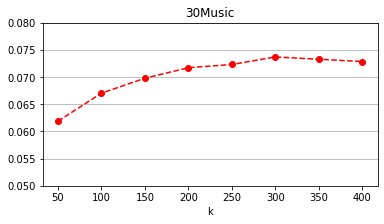

In [0]:
plt.figure(figsize=(6, 3))

k_ndcgs = [fm_evals[k_name]["ndcg"] for k_name in ["fm_lreg0.3"] + k_names]
plt.plot([50] + ks, k_ndcgs, "o--", color="red")
plt.xticks([50] + ks)
plt.ylim(bottom=0.05, top=0.08)
plt.grid(True, axis="y")

plt.xlabel("k")
plt.title("30Music");

In [0]:
k_hit_rates = [fm_evals[k_name]["hit_rate"] for k_name
               in ["fm_lreg0.3"] + k_names]
pd.DataFrame.from_records([k_ndcgs, k_hit_rates], columns=[50] + ks,
                          index=["NDCG", "Hit rate"])

,50,100,150,200,250,300,350,400
NDCG,0.061877,0.067039,0.069791,0.071717,0.072317,0.073701,0.07328,0.072859
Hit rate,0.008000,0.009000,0.010000,0.011000,0.014000,0.011000,0.01200,0.009000


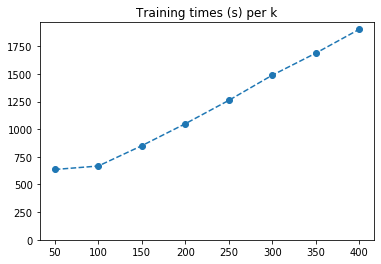

In [0]:
k_times = [fm_fits[k_name]["fit_time"] for k_name in ["fm_lreg0.3"] + k_names]
plt.plot([50] + ks, k_times, "o--")
plt.xticks([50] + ks)
plt.ylim(bottom=0.0)

plt.title("Training times (s) per k");

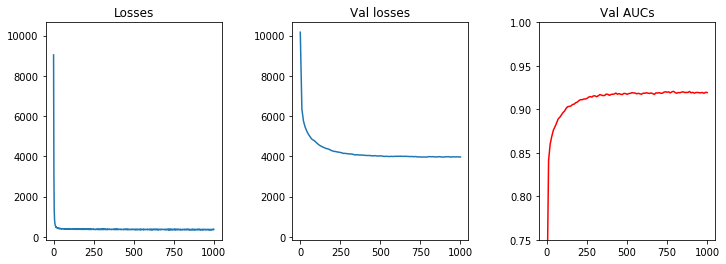

In [0]:
plot_fm_fit("fm_k150")

**Learning rate**

In [0]:
lrs = [0.3, 0.6, 1.0]
lr_names = ["fm_lr{}".format(lr) for lr in lrs]

for lr, lr_name in zip(lrs, lr_names):
  args = FMArgs(len(train_df), linear_reg=0.3, factors_reg=0.01, num_dims=150,
                lr=lr)
  fm = fit_fm_args(TfFM, args, lr_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, lr_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lr0.3.ckpt
0.015000 hit rate
0.074666 ndcg

839.39504s fit time
32.06329s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lr0.6.ckpt
0.010000 hit rate
0.069844 ndcg

843.92152s fit time
31.70436s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_lr1.0.ckpt
0.000000 hit rate
0.018799 ndcg

835.38323s fit time
31.61746s trans time


#### Sampling

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_lr0.1_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_uniform_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.1_e100.ckpt
0.015000 hit rate
0.060877 ndcg
37.38684s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.1_e250.ckpt
0.013000 hit rate
0.066959 ndcg
37.63077s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.1_e500.ckpt
0.013000 hit rate
0.070203 ndcg
37.20525s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.1_e1000.ckpt
0.014000 hit rate
0.074056 ndcg

3547.41389s fit time
37.25489s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_lr0.6_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_uniform_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.6_e100.ckpt
0.000000 hit rate
0.013795 ndcg
37.34152s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.6_e250.ckpt
0.002000 hit rate
0.014803 ndcg
37.23487s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.6_e500.ckpt
0.007000 hit rate
0.049790 ndcg
37.85845s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_lr0.6_e1000.ckpt
0.010000 hit rate
0.070468 ndcg

3557.69622s fit time
38.17546s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_aes_lr0.1_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_exp_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_aes_lr0.1_e100.ckpt
0.013000 hit rate
0.059897 ndcg
36.85488s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_aes_lr0.1_e250.ckpt
0.014000 hit rate
0.068870 ndcg
36.89908s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_aes_lr0.1_e500.ckpt
0.015000 hit rate
0.072660 ndcg
37.06899s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_b4096_aes_lr0.1_e1000.ckpt
0.014000 hit rate
0.076665 ndcg

3616.19064s fit time
37.64467s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003)

args_epochs = [100, 250, 500, 1000]
args_names = ["bfm_lr0.1_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfBatchFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_crossbatch_sampler,
                         val_sampler_fn=accepted_crossbatch_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.1_e100.ckpt
0.011000 hit rate
0.063952 ndcg
36.93284s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.1_e250.ckpt
0.014000 hit rate
0.070560 ndcg
37.15554s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.1_e500.ckpt
0.013000 hit rate
0.073054 ndcg
37.37425s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.1_e1000.ckpt
0.010000 hit rate
0.074310 ndcg

11258.91916s fit time
37.21911s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6)

args_epochs = [100, 250, 500, 1000]
args_names = ["bfm_lr0.6_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfBatchFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_crossbatch_sampler,
                         val_sampler_fn=accepted_crossbatch_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.6_e100.ckpt
0.015000 hit rate
0.075180 ndcg
36.73049s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.6_e250.ckpt
0.019000 hit rate
0.079713 ndcg
37.21587s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.6_e500.ckpt
0.018000 hit rate
0.079461 ndcg
36.83448s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_lr0.6_e1000.ckpt
0.020000 hit rate
0.082374 ndcg

12415.75441s fit time
36.71390s trans time


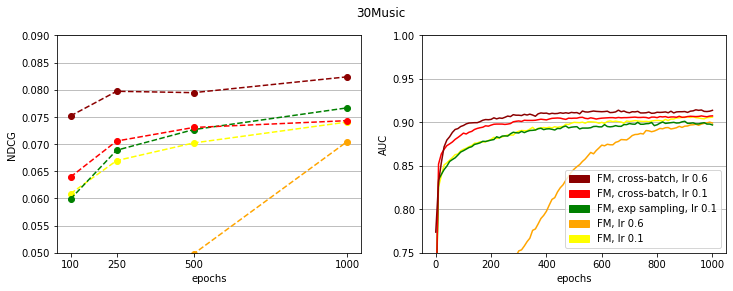

In [0]:
fm_names = ["fm_b4096_lr0.1_e{}".format(args_epoch) for args_epoch in args_epochs]
fm_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm_names]

fm1_names = ["fm_b4096_lr0.6_e{}".format(args_epoch) for args_epoch in args_epochs]
fm1_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm1_names]

fm_aes_names = ["fm_b4096_aes_lr0.1_e{}".format(args_epoch) for args_epoch in args_epochs]
fm_aes_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm_aes_names]

bfm_names = ["bfm_lr0.1_e{}".format(args_epoch) for args_epoch in args_epochs]
bfm_ndcgs = [fm_evals[bfm_name]["ndcg"] for bfm_name in bfm_names]

bfm1_names = ["bfm_lr0.6_e{}".format(args_epoch) for args_epoch in args_epochs]
bfm1_ndcgs = [fm_evals[bfm_name]["ndcg"] for bfm_name in bfm1_names]

plt.figure(figsize=(6*2, 4))
plt.suptitle("30Music")

plt.subplot(1, 2, 1)

plt.plot(args_epochs, fm_ndcgs, "o--", color="yellow")
plt.plot(args_epochs, fm1_ndcgs, "o--", color="orange")
plt.plot(args_epochs, fm_aes_ndcgs, "o--", color="green")
plt.plot(args_epochs, bfm_ndcgs, "o--", color="red")
plt.plot(args_epochs, bfm1_ndcgs, "o--", color="darkred")
plt.xticks(args_epochs)
plt.ylim(bottom=0.05, top=0.09)

plt.grid(True, axis="y")
plt.ylabel("NDCG")
plt.xlabel("epochs")

fm_aucs = fm_fits["fm_b4096_lr0.1_e1000"]["val_aucs"]
fm1_aucs = fm_fits["fm_b4096_lr0.6_e1000"]["val_aucs"]
fm_aes_aucs = fm_fits["fm_b4096_aes_lr0.1_e1000"]["val_aucs"]

bfm_aucs = fm_fits["bfm_lr0.1_e1000"]["val_aucs"]
bfm1_aucs = fm_fits["bfm_lr0.6_e1000"]["val_aucs"]

val_epochs = [i * args.eval_freq for i in range(len(fm_aucs))]

plt.subplot(1, 2, 2)

plt.grid(True, axis="y")
plt.plot(val_epochs, fm_aucs, color="yellow")
plt.plot(val_epochs, fm1_aucs, color="orange")
plt.plot(val_epochs, fm_aes_aucs, color="green")
plt.plot(val_epochs, bfm_aucs, color="red")
plt.plot(val_epochs, bfm1_aucs, color="darkred")
plt.ylim(bottom=0.75, top=1.0)

yellow_patch = mpatches.Patch(color="yellow", label="FM, lr 0.1")
orange_patch = mpatches.Patch(color="orange", label="FM, lr 0.6")
green_patch = mpatches.Patch(color="green", label="FM, exp sampling, lr 0.1")
red_patch = mpatches.Patch(color="red", label="FM, cross-batch, lr 0.1")
dred_patch = mpatches.Patch(color="darkred", label="FM, cross-batch, lr 0.6")
patches = [dred_patch, red_patch, green_patch, orange_patch, yellow_patch]
plt.legend(handles=patches)

plt.ylabel("AUC")
plt.xlabel("epochs");

In [0]:
args_labels = ["FM, lr 0.1", "FM, lr 0.3",
               "FM, cross-batch, lr 0.1", "FM, cross-batch, lr 0.3"]
args_names = ["fm_b4096_lr0.1_e1000", "fm_b4096_lr0.6_e1000",
              "bfm_lr0.1_e1000", "bfm_lr0.6_e1000"]
fit_times = [fm_fits[args_name]["fit_time"] for args_name in args_names]

pd.DataFrame.from_records([fit_times], columns=args_labels, index=["Fit times"])

,"FM, lr 0.1","FM, lr 0.3","FM, cross-batch, lr 0.1","FM, cross-batch, lr 0.3"
Fit times,3547.413894,3557.696224,11258.919159,12415.754406


In [0]:
sampler_names = ["us", "aus", "alus", "aaus",
                 "es", "aes", "ales", "aaes",
                 "is", "ais", "alis", "aais"]
sampler_names = ["fm_{}".format(name) for name in sampler_names]
sampler_fns = [uniform_sampler, accepted_uniform_sampler, accepted_album_uniform_sampler, accepted_artist_uniform_sampler,
               exp_sampler, accepted_exp_sampler, accepted_album_exp_sampler, accepted_artist_exp_sampler,
               instance_sampler, accepted_instance_sampler, accepted_album_instance_sampler, accepted_artist_instance_sampler]

args = FMArgs(len(train_df), num_dims=150, linear_reg=0.3, factors_reg=0.01)

for sampler_name, sampler_fn in zip(sampler_names, sampler_fns):
  fm = fit_fm_args(TfFM, args, sampler_name, train_df, val_query_df, val_df,
                   load=load, sampler_fn=sampler_fn)
  eval_fm(fm, sampler_name, val_query_df, val_df, filter_user_tracks=True,
          silent=True)

In [0]:
cols = ["all", "track", "album", "artist"]
index = ["uniform", "exp", "instance"]
rows = np.array([fm_evals[sampler_name]["ndcg"] for sampler_name
                 in sampler_names])
rows = rows.reshape((-1, len(cols)))
pd.DataFrame.from_records(rows, columns=cols, index=index)

,all,track,album,artist
uniform,0.070375,0.070290,0.070525,0.071412
exp,0.074210,0.074002,0.075196,0.076331
instance,0.074571,0.076715,0.075888,0.077859


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_us", train_df, val_query_df,
                 val_df, load=load)

eval_fm(fm, "bfm_us", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_us.ckpt
0.016000 hit rate
0.075877 ndcg

816.37512s fit time
37.29746s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_als", train_df, val_query_df,
                 val_df, load=load,
                 sampler_fn=accepted_album_crossbatch_sampler)

eval_fm(fm, "bfm_als", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_als.ckpt
0.015000 hit rate
0.074746 ndcg

1140.32122s fit time
37.11491s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_aas", train_df, val_query_df,
                 val_df, load=load,
                 sampler_fn=accepted_artist_crossbatch_sampler)

eval_fm(fm, "bfm_aas", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_aas.ckpt
0.015000 hit rate
0.073963 ndcg

1202.78220s fit time
37.19717s trans time


In [0]:
cols = ["all", "track", "album", "artist"]
index = ["cross-batch"]
rows = np.array([fm_evals[sampler_name]["ndcg"] for sampler_name
                 in [ "bfm_us", "bfm_lr0.6_e100", "bfm_als", "bfm_aas"]])
rows = rows.reshape((-1, len(cols)))
pd.DataFrame.from_records(rows, columns=cols, index=index)

,all,track,album,artist
cross-batch,0.075877,0.07518,0.074746,0.073963


#### Features

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_useritemfeats", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersitemfeats({}))

eval_fm(fm, "bfm_useritemfeats", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_useritemfeats.ckpt
0.021000 hit rate
0.095966 ndcg

926.83450s fit time
55.53238s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_all", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2all({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

fm_df = eval_fm(fm, "bfm_all", val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_all.ckpt
0.017000 hit rate
0.098047 ndcg

971.17779s fit time
88.41188s trans time


In [0]:
train_prev_df = train_df[train_df["prev_traid"] != 0]

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersprevitems())

eval_fm(fm, "bfm_prev", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_prev.ckpt
0.029000 hit rate
0.085455 ndcg

1027.22814s fit time
48.59017s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_previtemfeats", train_df,
                 val_query_df, val_df, load=load,
                 feature_fn=df2usersprevitemfeats({}))

eval_fm(fm, "bfm_previtemfeats", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_previtemfeats.ckpt
0.032000 hit rate
0.104563 ndcg

1254.72761s fit time
82.29885s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "bfm_prevall", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_prevall.ckpt
0.031000 hit rate
0.110650 ndcg

1296.75095s fit time
117.50125s trans time


In [0]:
args = FMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev_trans", train_prev_df, val_query_df,
                 val_df, load=load, item_ctx_features=True,
                 feature_fn=df2usersprevitems())

eval_fm(fm, "bfm_prev_trans", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_prev_trans.ckpt
0.027000 hit rate
0.089242 ndcg

809.28181s fit time
48.58658s trans time


In [0]:
args = FMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_previtemfeats_trans", train_prev_df,
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2usersprevitemfeats({}))

eval_fm(fm, "bfm_previtemfeats_trans", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_previtemfeats_trans.ckpt
0.036000 hit rate
0.116343 ndcg

954.46231s fit time
83.70596s trans time


In [0]:
args = FMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall_trans", train_prev_df,
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "bfm_prevall_trans", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_prevall_trans.ckpt
0.034000 hit rate
0.122059 ndcg

985.51283s fit time
115.69878s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

# train with TfBatchFM and load with SafeTfBatchFM - faster
fm = fit_fm_args(SafeTfBatchFM, args, "bfm_encodedusersprevall", train_df,
                 val_query_df, val_df, load=True, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "bfm_encodedusersprevall", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_encodedusersprevall.ckpt
0.026824 hit rate
0.114953 ndcg

3780.60588s fit time
397.16727s trans time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

# train with TfBatchFM and load with SafeTfBatchFM - faster
fm = fit_fm_args(SafeTfBatchFM, args, "bfm_encodedusersprevall_equi", train_df,
                 val_query_df, val_df, load=True, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25},
                     equi_weight_normalize))

eval_fm(fm, "bfm_encodedusersprevall_equi", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_encodedusersprevall_equi.ckpt
0.025751 hit rate
0.112990 ndcg

3804.99776s fit time
392.22580s trans time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

# train with TfBatchFM and load with SafeTfBatchFM - faster
fm = fit_fm_args(SafeTfBatchFM, args, "bfm_encodedusersprevall_ones", train_df,
                 val_query_df, val_df, load=True, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25},
                     one_weight_normalize))

eval_fm(fm, "bfm_encodedusersprevall_ones", val_query_df, val_df,
        filter_user_tracks=True);

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(dataset)`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bfm_encodedusersprevall_ones.ckpt
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
0.003219 hit rate
0.044651 ndcg

3778.24739s fit time
378.63920s trans time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Vanilla factorization machines

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096*4,
              linear_reg=0.3, factors_reg=0.01, epochs=100)

fm = fit_fm_args(TfFM, args, "fm_prevall", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "fm_prevall", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/fm_prevall.ckpt
0.026000 hit rate
0.104923 ndcg

643.85956s fit time
137.88134s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096*4,
              linear_reg=0.3, factors_reg=0.01, epochs=100)

fm = fit_fm_args(TfVanillaFM, args, "vfm_prevall", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "vfm_prevall", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/vfm_prevall.ckpt
0.030000 hit rate
0.094679 ndcg

1536.24388s fit time
1098.67023s trans time


### TransRec factorization machines

In [0]:
args = TransRecFMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
                      linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchTransRecFM, args, "btransfm", train_prev_df,
                 val_query_df, val_df, load=load, separate_features=True,
                 item_ctx_features=True,
                 feature_fn=df2usersprevitems())

eval_fm(fm, "btransfm", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/btransfm.ckpt
0.021000 hit rate
0.087037 ndcg

975.65339s fit time
40.14796s trans time


In [0]:
args = TransRecFMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
                      linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=100)

fm = fit_fm_args(TfBatchTransRecFM, args, "btransfm_prevall", train_prev_df,
                 val_query_df, val_df, load=load, separate_features=True,
                 item_ctx_features=True,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "btransfm_prevall", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/btransfm_prevall.ckpt
0.040000 hit rate
0.131213 ndcg

1207.31218s fit time
83.18025s trans time


### Field-Aware factorization machines

In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=1, num_item_fields=3,
               num_dims=50, linear_reg=0.1, factors_reg=0.003, epochs=10,
               batch_size=4096, lr=0.6)

fm = fit_fm_args(TfBatchFFM, args, "bffm_itemfeats", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2usersitemfeats({}))

eval_fm(fm, "bffm_itemfeats", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bffm_itemfeats.ckpt
0.024000 hit rate
0.095122 ndcg

75.23229s fit time
45.67021s trans time


In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=5, num_item_fields=3,
               num_dims=50, linear_reg=0.1, factors_reg=0.003, epochs=10,
               batch_size=4096, lr=0.6)

fm = fit_fm_args(TfBatchFFM, args, "bffm_all", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2all({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "bffm_all", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bffm_all.ckpt
0.019000 hit rate
0.095294 ndcg

131.39163s fit time
78.03614s trans time


In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=5+3, num_item_fields=3,
               num_dims=50, linear_reg=0.1, factors_reg=0.003, epochs=10,
               batch_size=4096, lr=0.6)

fm = fit_fm_args(TfBatchFFM, args, "bffm_prevall", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "bffm_prevall", val_query_df, val_df, filter_user_tracks=True);

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 127330800 elements. This may consume a large amount of memory.
  num_elements)


INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/bffm_prevall.ckpt
0.000000 hit rate
0.000368 ndcg

196.83139s fit time
103.28775s trans time


### Distributed factorization machines

We save the preprocessed data frame to CSV, so they can be loaded in Spark for the distributed factorization machine implementation.

In [0]:
train_df = train_df.drop(columns=["timestamp", "age"])
val_df = val_df.drop(columns=["timestamp", "age"])
val_query_df = val_query_df.drop(columns=["timestamp", "age"])

In [0]:
val_queryseeds_df = get_query_seeds(val_query_df)
val_queryctx_df = get_query_ctx(val_query_df)

In [0]:
max_user_cols = ["pid", "userid", "country", "gender", "b_age"]
max_item_cols = ["traid", "artid", "albid"]
max_prev_item_cols = ["prev_traid", "prev_artid", "prev_albid"]

max_df = train_df[max_user_cols + max_item_cols].max()
for prev_col, col in zip(max_prev_item_cols, max_item_cols):
  max_df[prev_col] = max_df[col]

train_df = (train_df - 1) % max_df
val_df = (val_df - 1) % max_df
val_queryseeds_df = (val_queryseeds_df - 1) % max_df
val_queryctx_df = (val_queryctx_df - 1) % max_df

In [0]:
train_df.to_csv("30Music-train.csv")
val_df.to_csv("30Music-val.csv")
val_queryseeds_df.to_csv("30Music-val-queryseeds.csv")
val_queryctx_df.to_csv("30Music-val-queryctx.csv")

### Final

In [0]:
train_df, test_df, test_query_df = last_track_split(df, as_val=False,
                                                    n_test_users=1000)

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6)

fm = fit_fm_args(TfBatchFM, args, "f_bfm", train_df, test_query_df,
                 test_df, load=load)

eval_fm(fm, "f_bfm", test_query_df, test_df, filter_user_tracks=True,
        with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/f_bfm.ckpt
0.011000 hit rate
0.069009 ndcg

8450.57844s fit time
42.70414s trans time


In [0]:
train_prev_df = train_df[train_df["prev_traid"] != 0]

In [0]:
args = FMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6)

fm = fit_fm_args(TfBatchFM, args, "f_bfm_prevall", train_prev_df, test_query_df,
                 test_df, load=load, item_ctx_features=True,
                 feature_fn=df2prevall({
                     "country": 0.25,
                     "gender": 0.5,
                     "b_age": 0.25}))

eval_fm(fm, "f_bfm_prevall", test_query_df, test_df, filter_user_tracks=True,
        with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/f_bfm_prevall.ckpt
0.026000 hit rate
0.114410 ndcg

9827.94408s fit time
136.91317s trans time


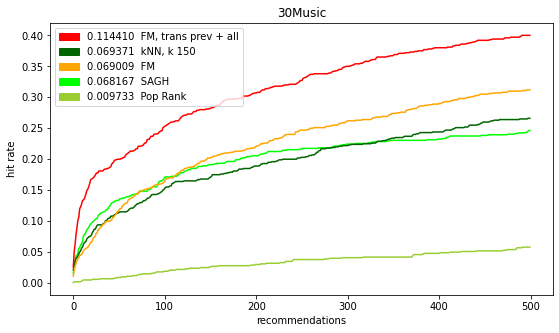

In [0]:
def plot_final_hit_rates(n=500):
  plt.figure(figsize=(9, 5))
  plt.plot(pop_rank_hit_rates[:n], color="yellowgreen")
  plt.plot(sagh_hit_rates[:n], color="lime")
  plt.plot(knn150_hit_rates[:n], color="darkgreen")
  plt.plot(fm_evals["f_bfm"]["hit_rates"], color="orange")
  plt.plot(fm_evals["f_bfm_prevall"]["hit_rates"], color="red")

  yellowgreen_patch = mpatches.Patch(color="yellowgreen", label="{:.6f}  Pop Rank".format(
      pop_rank_ndcg))
  green_patch = mpatches.Patch(color="lime", label="{:.6f}  SAGH".format(
      sagh_ndcg))
  dgreen_patch = mpatches.Patch(color="darkgreen", label="{:.6f}  kNN, k 150".format(
      knn150_ndcg))
  orange_patch = mpatches.Patch(color="orange", label="{:.6f}  FM".format(
      fm_evals["f_bfm"]["ndcg"]))
  red_patch = mpatches.Patch(color="red", label="{:.6f}  FM, trans prev + all".format(
      fm_evals["f_bfm_prevall"]["ndcg"])) 
  patches = [red_patch, dgreen_patch, orange_patch, green_patch, yellowgreen_patch]
  plt.legend(handles=patches)

  plt.ylabel("hit rate")
  plt.xlabel("recommendations")
  plt.title("30Music")
  
plot_final_hit_rates();

## Cold start evaluation

### Final

In [0]:
train_df, test_df, test_query_df = users_split(df, 1000, n_seed_tracks=5)

In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6)

fm = fit_fm_args(TfBatchFM, args, "cf_bfm", train_df, test_query_df,
                 test_df, load=load,
                 feature_fn=df2encodedusersitems())

eval_fm(fm, "cf_bfm", test_query_df, test_df, filter_user_tracks=True,
        with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/cf_bfm.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.005548 hit rate
0.139864 ndcg

32072.09113s fit time
71.83585s trans time


In [0]:
train_prev_df = train_df[train_df["prev_traid"] != 0]

In [0]:
args = FMArgs(len(train_prev_df), num_dims=150, batch_size=4096,
              linear_reg=0.1, factors_reg=0.003, lr=0.6, epochs=1000)

args_epochs = [500, 750, 900]
args_names = ["cf_bfm_prevall_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfBatchFM, args, args_names, args_epochs,
                         train_prev_df, test_query_df, test_df, load=load,
                         item_ctx_features=True,
                         feature_fn=df2encodedusersprevall({
                             "country": 0.25,
                             "gender": 0.5,
                             "b_age": 0.25
                             }))

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, test_query_df, test_df, filter_user_tracks=True,
          with_hit_rates=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/cf_bfm_prevall_e500.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.012289 hit rate
0.164382 ndcg
152.09054s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/cf_bfm_prevall_e750.ckpt
0.012304 hit rate
0.164639 ndcg
154.55485s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/30music/cf_bfm_prevall_e900.ckpt
0.011777 hit rate
0.164886 ndcg
154.31093s trans time


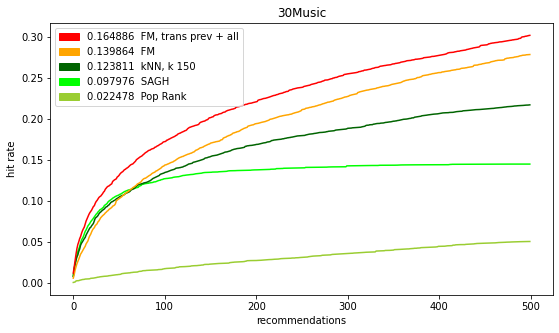

In [0]:
def plot_final_hit_rates(n=500):
  plt.figure(figsize=(9, 5))
  plt.plot(c_pop_rank_hit_rates[:n], color="yellowgreen")
  plt.plot(c_sagh_hit_rates[:n], color="lime")
  plt.plot(c_knn150_hit_rates[:n], color="darkgreen")
  plt.plot(fm_evals["cf_bfm"]["hit_rates"], color="orange")
  plt.plot(fm_evals["cf_bfm_prevall_e900"]["hit_rates"], color="red")

  yellowgreen_patch = mpatches.Patch(color="yellowgreen", label="{:.6f}  Pop Rank".format(
      c_pop_rank_ndcg))
  green_patch = mpatches.Patch(color="lime", label="{:.6f}  SAGH".format(
      c_sagh_ndcg))
  dgreen_patch = mpatches.Patch(color="darkgreen", label="{:.6f}  kNN, k 150".format(
      c_knn150_ndcg))
  orange_patch = mpatches.Patch(color="orange", label="{:.6f}  FM".format(
      fm_evals["cf_bfm"]["ndcg"]))
  red_patch = mpatches.Patch(color="red", label="{:.6f}  FM, trans prev + all".format(
      fm_evals["cf_bfm_prevall_e900"]["ndcg"])) 
  patches = [red_patch, orange_patch,
             dgreen_patch, green_patch, yellowgreen_patch]
  plt.legend(handles=patches)

  plt.ylabel("hit rate")
  plt.xlabel("recommendations")
  plt.title("30Music")
  
plot_final_hit_rates();